202120 – DATA-201-23387

Minh Tu Bui

December 16, 2020

Capstone Project - Final Report


# Overview
The project focuses on the records of the police dispatched incidents in Montgomery County from 2017 to present. The main objectives are to conduct the forecast for the number of incidents using the time-series data, evaluate the responsiveness of the police stations in terms of travel distance to the incident locations, and recommend the optimal location of the current and new police stations. 

The main dataset is the “Police Dispatched Incidents” from dataMontgomery that provides relevant information about crime types, incident locations and police district numbers. The analysis uses the additional “Police Station” dataset to generate significant findings that support the ultimate objectives of the project. The main programming language in the report is Python with multiple packages and libraries and Tableau Public for mapping visualization.


In [1]:
!pip install tqdm==4.36.0
!pip install vincenty
!pip install pystan
!pip install fbprophet
!pip install shapely

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import numpy as np
import geopandas as gpd
import geopy
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
import plotly_express 
import tqdm
from tqdm._tqdm_notebook import tqdm_notebook
import scipy.stats as stats
from scipy.stats import f_oneway
import statsmodels.api as sm
from statsmodels.formula.api import ols
from vincenty import vincenty
import warnings
import itertools
from shapely.geometry import MultiPoint

C:\Users\Tu\anaconda3\lib\site-packages\ipykernel_launcher.py:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.*` instead of `tqdm._tqdm_notebook.*`
  if sys.path[0] == '':


# Data Ingestion and Wrangling

The analysis reads the data of the main dataset “Police Dispatched Incidents” directly from the dataMontgomery urls so that the report has the most updated data.  The “Police Station” dataset has fixed information; therefore, the analysis uses the .csv file downloaded from the website.

The column names are adjusted from “name name” to “name_name” format so that all of the column names are consistent, which helps referencing the variables in the commands. The number of columns reduces from 26 to 17 as the report keeps the information needed for the analysis. 

In [3]:
# Load the first dataset "Police Dispatched Incidents"
# dispatch = pd.read_csv('Police_Dispatched_Incidents.csv')
url = 'https://data.montgomerycountymd.gov/api/views/98cc-bc7d/rows.csv?accessType=DOWNLOAD'
dispatch = pd.read_csv(url)

C:\Users\Tu\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (2,11,16) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
# Change the format of column names
dispatch.columns = dispatch.columns.str.replace(' ', '_')

In [5]:
# View the first few lines of "Police Dispatched Incidents" dataset
dispatch.head()

,Incident_ID,Crime_Reports,Crash_Reports,Start_Time,End_Time,Priority,Initial_Type,Close_Type,Address,City,...,PRA,CallTime_CallRoute,Calltime_Dispatch,Calltime_Arrive,Calltime_Cleared,CallRoute_Dispatch,Dispatch_Arrive,Arrive_Cleared,Disposition_Desc,Location
0,P1700500000,NaN,NaN,04/02/2017 06:38:46 AM,04/02/2017 06:40:20 AM,4,"MISC-ADMIN (DOCUMENT, LOST OR FOUND PROPERTY, ...","MISC-ADMIN (DOCUMENT, LOST OR FOUND PROPERTY, ...",2300 BLK RANDOLPH RD,SILVER SPRING,...,536,45.0,68.0,NaN,93.0,22.0,NaN,NaN,OTHERMISCELLANEOUS,POINT (-77.0484 39.0584)
1,P1700500036,NaN,NaN,04/02/2017 08:31:55 AM,04/02/2017 08:52:32 AM,1,ALARMB - ALARM BURGLARY/INTRUSION,ALARMB - ALARM BURGLARY/INTRUSION,8900 BLK FAIRVIEW RD,SILVER SPRING,...,107,451.0,768.0,1022.0,1236.0,316.0,253.0,214.0,ALARMRESID-UNKNOWNCAUS,POINT (-77.0293 39.0007)
2,P1700803509,170543590,NaN,11/18/2017 03:13:42 PM,11/18/2017 10:26:09 PM,0,ASSAULT,ROBBERY,8300 BLK FENTON ST,SILVER SPRING,...,110,108.0,135.0,346.0,25946.0,26.0,211.0,25599.0,ROBSTNGARM-COMM,POINT (-77.0241 38.9931)
3,P1700500127,NaN,NaN,04/02/2017 10:49:30 AM,04/02/2017 04:03:37 PM,4,MIS - MISC ON PATROL,MIS - MISC ON PATROL,1 BLK W MONTGOMERY AVE,ROCKVILLE,...,255,201.0,218.0,267.0,18846.0,17.0,48.0,18579.0,OTHERMISCELLANEOUS,POINT (-77.1529 39.0842)
4,P1700500146,NaN,NaN,04/02/2017 11:13:31 AM,04/02/2017 11:34:49 AM,2,DISTURBANCE/NUISANCE,DISTURBANCE/NUISANCE,13000 BLK PARKLAND DR,ROCKVILLE,...,527,98.0,249.0,992.0,1278.0,150.0,743.0,286.0,SUSPICIOUSSIT/PRSON/VEH,POINT (-77.0888 39.0691)


In [6]:
# View the shape of the first dataset
dispatch.shape

(779346, 26)

In [7]:
# Remove columns "Crime_Reports", "Crash_Reports","State", "Address", "Initial_Type", "Zip", "Beat", "PRA", "Disposition_Desc" of the dataset
dispatch = dispatch.drop(["Crime_Reports", "Crash_Reports","State", 
                          "Address", "Initial_Type", "Zip", 
                          "Beat", "PRA", "Disposition_Desc"], axis = 1)
dispatch.shape

(779346, 17)

In [8]:
dispatch.dtypes

Incident_ID                object
Start_Time                 object
End_Time                   object
Priority                    int64
Close_Type                 object
City                       object
Longitude                 float64
Latitude                  float64
Police_District_Number     object
CallTime_CallRoute        float64
Calltime_Dispatch         float64
Calltime_Arrive           float64
Calltime_Cleared          float64
CallRoute_Dispatch        float64
Dispatch_Arrive           float64
Arrive_Cleared            float64
Location                   object
dtype: object

In [9]:
dispatch.describe(include = 'all')

,Incident_ID,Start_Time,End_Time,Priority,Close_Type,City,Longitude,Latitude,Police_District_Number,CallTime_CallRoute,Calltime_Dispatch,Calltime_Arrive,Calltime_Cleared,CallRoute_Dispatch,Dispatch_Arrive,Arrive_Cleared,Location
count,779346,779346,779342,779346.000000,779346,778591,779321.000000,779321.000000,779346,779311.000000,751913.000000,609158.000000,779242.000000,751912.000000,608280.000000,609119.000000,779321
unique,779346,776314,776236,NaN,182,51,NaN,NaN,9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40788
top,P2000034518,12/02/2017 01:42:31 PM,06/02/2017 02:40:44 PM,NaN,TRAFFIC/TRANSPORTATION INCIDENT,SILVER SPRING,NaN,NaN,4D,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (0 0)
freq,1,4,3,NaN,60443,257586,NaN,NaN,151200,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13931
mean,NaN,NaN,NaN,1.811886,NaN,NaN,-75.742196,38.387373,NaN,153.275617,784.161833,1351.105991,3014.711127,629.463073,681.927509,1804.026542,NaN
std,NaN,NaN,NaN,1.247623,NaN,NaN,10.218968,5.179381,NaN,218.758137,1647.070897,1958.274389,4362.897821,1629.380129,1431.858624,3431.168531,NaN
min,NaN,NaN,NaN,0.000000,NaN,NaN,-81.529100,0.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN
25%,NaN,NaN,NaN,1.000000,NaN,NaN,-77.198500,39.028590,NaN,85.000000,208.000000,564.000000,1176.000000,72.000000,246.000000,365.000000,NaN
50%,NaN,NaN,NaN,1.000000,NaN,NaN,-77.113700,39.078890,NaN,124.000000,346.000000,900.000000,2022.000000,184.000000,456.000000,842.000000,NaN
75%,NaN,NaN,NaN,3.000000,NaN,NaN,-77.044700,39.144910,NaN,183.000000,695.000000,1533.000000,3643.000000,506.000000,808.000000,1981.000000,NaN


## "Start_Time" Variable

The variable consists of the records of the time when the emergency center receives the calls. The report applies the date/time data type that is important in the time-series analysis. The recorded timeline is from July 2017 to present as the dataset is updated daily.

In [10]:
# Count missing values
dispatch.Start_Time.isnull().sum()

0

In [11]:
# Change to Start_Time to Date
dispatch.Start_Time = pd.to_datetime(dispatch.Start_Time).dt.date
dispatch.Start_Time.head()

0    2017-04-02
1    2017-04-02
2    2017-11-18
3    2017-04-02
4    2017-04-02
Name: Start_Time, dtype: object

In [12]:
dispatch.head()

,Incident_ID,Start_Time,End_Time,Priority,Close_Type,City,Longitude,Latitude,Police_District_Number,CallTime_CallRoute,Calltime_Dispatch,Calltime_Arrive,Calltime_Cleared,CallRoute_Dispatch,Dispatch_Arrive,Arrive_Cleared,Location
0,P1700500000,2017-04-02,04/02/2017 06:40:20 AM,4,"MISC-ADMIN (DOCUMENT, LOST OR FOUND PROPERTY, ...",SILVER SPRING,-77.0484,39.05842,4D,45.0,68.0,NaN,93.0,22.0,NaN,NaN,POINT (-77.0484 39.0584)
1,P1700500036,2017-04-02,04/02/2017 08:52:32 AM,1,ALARMB - ALARM BURGLARY/INTRUSION,SILVER SPRING,-77.0293,39.00069,3D,451.0,768.0,1022.0,1236.0,316.0,253.0,214.0,POINT (-77.0293 39.0007)
2,P1700803509,2017-11-18,11/18/2017 10:26:09 PM,0,ROBBERY,SILVER SPRING,-77.0241,38.99306,3D,108.0,135.0,346.0,25946.0,26.0,211.0,25599.0,POINT (-77.0241 38.9931)
3,P1700500127,2017-04-02,04/02/2017 04:03:37 PM,4,MIS - MISC ON PATROL,ROCKVILLE,-77.1529,39.08423,1D,201.0,218.0,267.0,18846.0,17.0,48.0,18579.0,POINT (-77.1529 39.0842)
4,P1700500146,2017-04-02,04/02/2017 11:34:49 AM,2,DISTURBANCE/NUISANCE,ROCKVILLE,-77.0888,39.06914,4D,98.0,249.0,992.0,1278.0,150.0,743.0,286.0,POINT (-77.0888 39.0691)


## "Priority" Variable

In [13]:
# Count the number of incidents per priority levels
dispatch.Priority.value_counts()

1    330047
2    179437
4    138577
0     75002
3     56279
5         4
Name: Priority, dtype: int64

In [14]:
# Information of the 4 incidents with the Priority level recorded as 5
dispatch[dispatch.Priority == 5]

,Incident_ID,Start_Time,End_Time,Priority,Close_Type,City,Longitude,Latitude,Police_District_Number,CallTime_CallRoute,Calltime_Dispatch,Calltime_Arrive,Calltime_Cleared,CallRoute_Dispatch,Dispatch_Arrive,Arrive_Cleared,Location
27915,P1700563398,2017-05-19,05/19/2017 07:24:11 PM,5,FOLLOW UP/SUPPLEMENTAL INFORMATION - OCCURRED ...,BROOKEVILLE,-77.0998,39.17874,4D,0.0,800.0,1695.0,2856.0,800.0,894.0,1160.0,POINT (-77.0998 39.1787)
41568,P1700590673,2017-06-08,06/08/2017 06:15:21 PM,5,FOLLOW UP/SUPPLEMENTAL INFORMATION - OCCURRED ...,MONTGOMERY VILLAGE,-77.1835,39.18647,6D,0.0,137.0,578.0,1962.0,137.0,440.0,1384.0,POINT (-77.1835 39.1865)
106279,P1700718816,2017-09-14,09/14/2017 12:06:18 PM,5,FOLLOW UP/SUPPLEMENTAL INFORMATION - OCCURRED ...,ROCKVILLE,-77.1185,39.03293,2D,0.0,2331.0,2726.0,4486.0,2331.0,395.0,1760.0,POINT (-77.1185 39.0329)
506398,P1700591614,2017-06-09,06/09/2017 01:05:38 PM,5,FOLLOW UP/SUPPLEMENTAL INFORMATION - OCCURRED ...,SILVER SPRING,-77.0389,39.01969,3D,0.0,279.0,5771.0,8476.0,279.0,5492.0,2704.0,POINT (-77.0389 39.0197)


In [15]:
# Remove the 4 incidents with the Priority level recorded as 5. 
# Most of the cases are "Follow up" and the 'Follow up' cases contains all for priority levels.
dispatch = dispatch[dispatch.Priority != 5]
dispatch.shape

(779342, 17)

In [16]:
# Count missing values in the "Priority" column
dispatch.Priority.isnull().sum()

0

In [17]:
# Show number of calls per priority level
dispatch.Priority.value_counts()

1    330047
2    179437
4    138577
0     75002
3     56279
Name: Priority, dtype: int64

## "Police District Number" Variable

In [18]:
# Show number of calls per police district
dispatch['Police_District_Number'].value_counts()

4D     151199
3D     150694
6D     131994
1D     124504
2D     120482
5D     100317
TRU        81
PCW        37
OOC        34
Name: Police_District_Number, dtype: int64

In [19]:
# Show calls that are classified as TRU (Telephone reporting unit)
dispatch[dispatch['Police_District_Number'] == "TRU"]

,Incident_ID,Start_Time,End_Time,Priority,Close_Type,City,Longitude,Latitude,Police_District_Number,CallTime_CallRoute,Calltime_Dispatch,Calltime_Arrive,Calltime_Cleared,CallRoute_Dispatch,Dispatch_Arrive,Arrive_Cleared,Location
3569,P1700513742,2017-04-12,04/12/2017 12:36:31 PM,4,THEFTT - TRS THEFT/LARCENY - TELEPHONE REPORTI...,SILVER SPRING,-77.0685,39.04610,TRU,60.0,7837.0,NaN,9010.0,7777.0,NaN,NaN,POINT (-77.0685 39.0461)
7123,P1700520819,2017-04-17,04/18/2017 12:14:19 AM,4,THEFTT - TRS THEFT/LARCENY - TELEPHONE REPORTI...,ROCKVILLE,-77.1133,39.04181,TRU,244.0,11180.0,NaN,12711.0,10936.0,NaN,NaN,POINT (-77.1133 39.0418)
9925,P1700526862,2017-04-22,04/22/2017 10:33:16 AM,4,THEFTT - TRS THEFT/LARCENY - TELEPHONE REPORTI...,SILVER SPRING,-77.0009,38.99849,TRU,138.0,270.0,NaN,1014.0,132.0,NaN,NaN,POINT (-77.0009 38.9985)
24972,P1700557008,2017-05-15,05/15/2017 02:43:19 PM,4,"LOSTT-TRS ADMIN (DOCUMENT, LOST OR FOUND PROP,...",SILVER SPRING,0.0000,0.00000,TRU,103.0,6278.0,NaN,9819.0,6174.0,NaN,NaN,POINT (0 0)
31808,P1700571084,2017-05-25,05/25/2017 03:47:26 PM,4,THEFTT - TRS THEFT/LARCENY - TELEPHONE REPORTI...,DERWOOD,-77.1662,39.11558,TRU,272.0,363.0,NaN,1791.0,91.0,NaN,NaN,POINT (-77.1662 39.1156)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
768690,P2000291432,2020-11-12,11/12/2020 05:17:15 PM,4,"HARASST-TRS HARASSMENT, STALKING, THREATS - TE...",GAITHERSBURG,-77.2119,39.16290,TRU,459.0,1485.0,NaN,3694.0,1025.0,NaN,NaN,POINT (-77.2119 39.1629)
769088,P2000295062,2020-11-16,11/16/2020 04:05:13 PM,4,"LOSTT-TRS ADMIN (DOCUMENT, LOST OR FOUND PROP,...",SILVER SPRING,-76.9579,39.05949,TRU,111.0,2101.0,NaN,7391.0,1989.0,NaN,NaN,POINT (-76.9579 39.0595)
769625,P2000268631,2020-10-19,10/19/2020 07:40:24 PM,4,THEFTT - TRS THEFT/LARCENY - TELEPHONE REPORTI...,SILVER SPRING,-76.9351,39.08094,TRU,162.0,1084.0,NaN,3641.0,921.0,NaN,NaN,POINT (-76.9351 39.0809)
775244,P2000278362,2020-10-29,10/30/2020 12:05:33 AM,4,THEFTT - TRS THEFT/LARCENY - TELEPHONE REPORTI...,DERWOOD,-77.1420,39.13689,TRU,214.0,404.0,NaN,3127.0,189.0,NaN,NaN,POINT (-77.142 39.1369)


In [20]:
# Show calls that are classified as OOC (Out of county)
dispatch[dispatch['Police_District_Number'] == "OOC"]

,Incident_ID,Start_Time,End_Time,Priority,Close_Type,City,Longitude,Latitude,Police_District_Number,CallTime_CallRoute,Calltime_Dispatch,Calltime_Arrive,Calltime_Cleared,CallRoute_Dispatch,Dispatch_Arrive,Arrive_Cleared,Location
185906,P1900188153,2019-06-05,06/05/2019 08:42:17 PM,4,S - SUSPICIOUS SITUATION ON PATROL,WASHINGTON,-77.018600,38.978340,OOC,221.0,307.0,595.0,694.0,86.0,287.0,98.0,POINT (-77.0186 38.9783)
246255,P1900194736,2019-06-11,06/11/2019 12:08:42 PM,0,TRAFFIC/TRANSPORTATION INCIDENT,GREAT FALLS,0.000000,0.000000,OOC,155.0,NaN,NaN,392.0,NaN,NaN,NaN,POINT (0 0)
267362,P1800199060,2018-06-10,06/10/2018 07:07:43 AM,3,NOISE - NOISE - OTHER COMPLAINTS,SILVER SPRING,0.000000,0.000000,OOC,100.0,NaN,NaN,6969.0,NaN,NaN,NaN,POINT (0 0)
275712,P1900395221,2019-11-30,11/30/2019 11:58:26 AM,4,THEFTT - TRS THEFT/LARCENY - TELEPHONE REPORTI...,HYATTSVILLE,0.000000,0.000000,OOC,91.0,1339.0,NaN,1362.0,1248.0,NaN,NaN,POINT (0 0)
281727,P1800227342,2018-07-02,07/02/2018 08:46:25 PM,4,THEFTT - TRS THEFT/LARCENY - TELEPHONE REPORTI...,SILVER SPRING,-76.986500,38.998620,OOC,243.0,462.0,NaN,477.0,219.0,NaN,NaN,POINT (-76.9865 38.9986)
284078,P1800232138,2018-07-06,07/06/2018 02:15:02 PM,2,THEFT/LARCENY,SILVER SPRING,-76.982300,39.005030,OOC,178.0,NaN,NaN,388.0,NaN,NaN,NaN,POINT (-76.9823 39.005)
284551,P1800233083,2018-07-07,07/07/2018 07:42:17 AM,4,THEFTT - TRS THEFT/LARCENY - TELEPHONE REPORTI...,SILVER SPRING,0.000000,0.000000,OOC,127.0,200.0,NaN,639.0,72.0,NaN,NaN,POINT (0 0)
290979,P1800245951,2018-07-17,07/17/2018 01:38:36 PM,4,THEFTT - TRS THEFT/LARCENY - TELEPHONE REPORTI...,SILVER SPRING,0.000000,0.000000,OOC,161.0,457.0,NaN,6431.0,296.0,NaN,NaN,POINT (0 0)
315663,P1800296044,2018-08-27,08/27/2018 07:52:26 AM,4,"LOSTT-TRS ADMIN (DOCUMENT, LOST OR FOUND PROP,...",ALEXANDRIA,-77.147700,39.082720,OOC,73.0,NaN,NaN,290.0,NaN,NaN,NaN,POINT (-77.1477 39.0827)
344117,P1900361669,2019-11-01,11/01/2019 01:15:59 AM,0,TRAFFIC/TRANSPORTATION INCIDENT,LAUREL,0.000000,0.000000,OOC,173.0,197.0,NaN,313.0,23.0,NaN,NaN,POINT (0 0)


In [21]:
# Show calls that are classified as PCW (Police County Wide)
dispatch[dispatch['Police_District_Number'] == "PCW"]

,Incident_ID,Start_Time,End_Time,Priority,Close_Type,City,Longitude,Latitude,Police_District_Number,CallTime_CallRoute,Calltime_Dispatch,Calltime_Arrive,Calltime_Cleared,CallRoute_Dispatch,Dispatch_Arrive,Arrive_Cleared,Location
6802,P1700520218,2017-04-17,04/17/2017 01:09:04 PM,3,DISTURBANCE/NUISANCE - OCCURRED EARLIER,POTOMAC,-77.159400,39.055320,PCW,202.0,319.0,1221.0,2080.0,117.0,902.0,859.0,POINT (-77.1594 39.0553)
13079,P1700533508,2017-04-27,04/27/2017 03:34:26 PM,2,TRAFFIC VIOLATION,CHEVY CHASE,-77.081700,39.017360,PCW,112.0,627.0,868.0,1914.0,515.0,241.0,1045.0,POINT (-77.0817 39.0174)
31437,P1700560308,2017-05-17,05/17/2017 07:05:29 PM,2,TRAFFIC VIOLATION,BETHESDA,0.000000,0.000000,PCW,510.0,1886.0,1994.0,3090.0,1376.0,108.0,1095.0,POINT (0 0)
40700,P1700588819,2017-06-07,06/07/2017 03:36:51 PM,4,THEFTT - TRS THEFT/LARCENY - TELEPHONE REPORTI...,SILVER SPRING,0.000000,0.000000,PCW,131.0,9665.0,NaN,10648.0,9534.0,NaN,NaN,POINT (0 0)
42903,P1700579158,2017-05-31,05/31/2017 09:50:08 PM,1,ANIMAL RESCUE,ROCKVILLE,0.000000,0.000000,PCW,123.0,503.0,1032.0,10572.0,380.0,529.0,9540.0,POINT (0 0)
43652,P1700594533,2017-06-11,06/11/2017 12:29:50 PM,0,MENTAL DISORDER - VIA FRS,SILVER SPRING,0.000000,0.000000,PCW,123.0,NaN,NaN,527.0,NaN,NaN,NaN,POINT (0 0)
47733,P1700602723,2017-06-17,06/17/2017 12:33:34 AM,1,"SUSPICIOUS CIRC, PERSONS, VEHICLE",DICKERSON,-77.385000,39.252460,PCW,211.0,NaN,NaN,398.0,NaN,NaN,NaN,POINT (-77.385 39.2525)
57183,P1700598775,2017-06-14,06/14/2017 02:57:26 PM,1,ANIMAL RESCUE,GAITHERSBURG,0.000000,0.000000,PCW,96.0,840.0,3191.0,6793.0,743.0,2350.0,3602.0,POINT (0 0)
68024,P1700641863,2017-07-16,07/16/2017 11:15:54 PM,4,"MISC-ADMIN (DOCUMENT, LOST OR FOUND PROPERTY, ...",COLUMBIA,0.000000,0.000000,PCW,95.0,NaN,NaN,95.0,NaN,NaN,NaN,POINT (0 0)
75230,P1700656472,2017-07-27,07/27/2017 10:39:27 PM,4,"MISC-ADMIN (DOCUMENT, LOST OR FOUND PROPERTY, ...",GAITHERSBURG,0.000000,0.000000,PCW,1095.0,1181.0,1289.0,2967.0,85.0,108.0,1678.0,POINT (0 0)


In [22]:
# Drop records with the police district number "TRU", "PCW", "OOC" . Reason: The TRU unit is our non-emergency office.  
# The calls you see listed as TRU were deemed non-emergency and were transferred from the 911 call center.  
# No effort was made to geocode the address and no one was dispatched, so no district was calculated. 
# Furthermore, for the purpose of calculating the distance between police stations and incidents, these should be removed.
district_outliers = ["TRU", "PCW", "OOC"]
dispatch = dispatch[dispatch.Police_District_Number.isin(district_outliers) == False]
dispatch.Police_District_Number.value_counts()

4D    151199
3D    150694
6D    131994
1D    124504
2D    120482
5D    100317
Name: Police_District_Number, dtype: int64

## "City" Variable

The variable shows that the incident locations are not completely in Montgomery County and some locations belong to other counties in close proximity including Howard County, Prince George’s County, Anne Arundel County, and so forth. For the missing values in this variable, the Geopy library provides the implementation for third-party geocoders and other data sources to conduct the reverse geocoding that translates the coordinates of the incident locations to the actual addresses. The cities in the addresses are then retrieved for analyzing. The records with no information of City, Longitude and Latitude are removed.

In [23]:
# Number of incidents in each cities
dispatch.City.value_counts()

SILVER SPRING         257538
ROCKVILLE             122809
GAITHERSBURG          109308
GERMANTOWN             72076
BETHESDA               57038
MONTGOMERY VILLAGE     26011
POTOMAC                25662
CHEVY CHASE            18634
DERWOOD                13770
KENSINGTON             13296
OLNEY                  13273
CLARKSBURG             11975
BURTONSVILLE           11061
DAMASCUS                6921
BOYDS                   4135
BROOKEVILLE             4109
POOLESVILLE             2860
SANDY SPRING            1544
ASHTON                  1411
DICKERSON               1406
CABIN JOHN               818
SPENCERVILLE             498
GARRETT PARK             417
BRINKLOW                 317
WASHINGTON GROVE         245
GLEN ECHO                220
BELTSVILLE               203
BEALLSVILLE              189
MT AIRY                  156
LAUREL                   148
BARNESVILLE              136
MT. AIRY                  97
MOUNT AIRY                68
HIGHLAND                  27
WOODBINE      

Cities that do not belong to Montgomery County: Frederick, Fulton, Fairfax, College Park, Great Falls, Jessup, Lanham, Herndon, Columnbia, Monrovia, Hyattsville, Washington, Adelphi, Woodbine, Highland, Mount Airy, and Beltsville.

In [25]:
# Replace "Wheaton" by "WHEATON"
mask = dispatch.City == 'Wheaton'
mask.sum()

1

In [26]:
# Replace "Wheaton" by "WHEATON"
dispatch.loc[mask, 'City'] = dispatch.loc[mask,'City'].replace('Wheaton','WHEATON')
dispatch.City.value_counts()

SILVER SPRING         257538
ROCKVILLE             122809
GAITHERSBURG          109308
GERMANTOWN             72076
BETHESDA               57038
MONTGOMERY VILLAGE     26011
POTOMAC                25662
CHEVY CHASE            18634
DERWOOD                13770
KENSINGTON             13296
OLNEY                  13273
CLARKSBURG             11975
BURTONSVILLE           11061
DAMASCUS                6921
BOYDS                   4135
BROOKEVILLE             4109
POOLESVILLE             2860
SANDY SPRING            1544
ASHTON                  1411
DICKERSON               1406
CABIN JOHN               818
SPENCERVILLE             498
GARRETT PARK             417
BRINKLOW                 317
WASHINGTON GROVE         245
GLEN ECHO                220
BELTSVILLE               203
BEALLSVILLE              189
MT AIRY                  156
LAUREL                   148
BARNESVILLE              136
MT. AIRY                  97
MOUNT AIRY                68
HIGHLAND                  27
WOODBINE      

In [27]:
# Combine the incidents in Mount Airy
mask1 = dispatch.City.isin(['MT AIRY', 'MT. AIRY'])
mask1.sum()

253

In [28]:
# Combine the incidents in Mount Airy
dispatch.loc[mask1, 'City'] = dispatch.loc[mask1, 'City'].replace(["MT AIRY", "MT. AIRY"], "MOUNT AIRY")
dispatch['City'].value_counts()

SILVER SPRING         257538
ROCKVILLE             122809
GAITHERSBURG          109308
GERMANTOWN             72076
BETHESDA               57038
MONTGOMERY VILLAGE     26011
POTOMAC                25662
CHEVY CHASE            18634
DERWOOD                13770
KENSINGTON             13296
OLNEY                  13273
CLARKSBURG             11975
BURTONSVILLE           11061
DAMASCUS                6921
BOYDS                   4135
BROOKEVILLE             4109
POOLESVILLE             2860
SANDY SPRING            1544
ASHTON                  1411
DICKERSON               1406
CABIN JOHN               818
SPENCERVILLE             498
GARRETT PARK             417
MOUNT AIRY               321
BRINKLOW                 317
WASHINGTON GROVE         245
GLEN ECHO                220
BELTSVILLE               203
BEALLSVILLE              189
LAUREL                   148
BARNESVILLE              136
HIGHLAND                  27
WOODBINE                  23
ADELPHI                   13
WASHINGTON    

In [29]:
dispatch.shape

(779190, 17)

In [30]:
#Count missing values in "City" column
dispatch['City'].isnull().sum()

753

In [31]:
#Show rows that does not have "City" recorded
city_null = dispatch[dispatch['City'].isnull()]
city_null

,Incident_ID,Start_Time,End_Time,Priority,Close_Type,City,Longitude,Latitude,Police_District_Number,CallTime_CallRoute,Calltime_Dispatch,Calltime_Arrive,Calltime_Cleared,CallRoute_Dispatch,Dispatch_Arrive,Arrive_Cleared,Location
21,P1700534419,2017-04-28,04/28/2017 08:34:50 AM,2,TRAFFIC/TRANSPORTATION INCIDENT,NaN,-77.040589,39.009576,3D,51.0,98.0,2570.0,4407.0,46.0,2472.0,1836.0,POINT (-77.0406 39.0096)
36,P1700500958,2017-04-03,04/03/2017 12:59:12 AM,1,ANIMAL COMPL,NaN,-77.196249,39.086873,1D,56.0,340.0,764.0,1179.0,283.0,423.0,415.0,POINT (-77.1962 39.0869)
42,P1700501109,2017-04-03,04/03/2017 07:30:52 AM,2,ASSIST OTHER AGENCY,NaN,-77.323586,39.277714,5D,0.0,169.0,955.0,3790.0,169.0,785.0,2835.0,POINT (-77.3236 39.2777)
58,P1700501813,2017-04-03,04/03/2017 04:28:02 PM,2,ASSIST OTHER AGENCY,NaN,-77.117703,38.991318,2D,0.0,235.0,663.0,2249.0,235.0,427.0,1586.0,POINT (-77.1177 38.9913)
60,P1700501875,2017-04-03,04/03/2017 04:48:39 PM,1,RESCUE WITH FRS,NaN,-77.055425,39.040017,4D,243.0,1175.0,1200.0,1534.0,932.0,25.0,333.0,POINT (-77.0554 39.04)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
716471,P2000188866,2020-07-23,07/23/2020 12:55:47 PM,1,"SUSPICIOUS CIRC, PERSONS, VEHICLE",NaN,0.000000,0.000000,6D,173.0,387.0,NaN,1306.0,213.0,NaN,NaN,POINT (0 0)
724185,P2000180099,2020-07-13,07/13/2020 03:37:30 PM,4,"THREATT - TRS HARASSMENT, STALKING, THREATS - ...",NaN,0.000000,0.000000,6D,195.0,3172.0,NaN,5150.0,2977.0,NaN,NaN,POINT (0 0)
738401,P2000213238,2020-08-19,08/19/2020 07:48:25 PM,4,FOLLOWT-TRS / SUPPLEMENTAL INFORMATION - TELEP...,NaN,0.000000,0.000000,4D,118.0,1989.0,NaN,3238.0,1871.0,NaN,NaN,POINT (0 0)
750946,P2000239778,2020-09-17,09/17/2020 11:16:03 PM,1,CHECK WELFARE,NaN,0.000000,0.000000,4D,251.0,440.0,938.0,5968.0,188.0,498.0,5029.0,POINT (0 0)


In [32]:
# Number of records with no city and no coordinates
dispatch[(dispatch['City'].isnull()) & (dispatch['Location'] == "POINT (0 0)")].shape

(53, 17)

In [33]:
# Drop records that do not have "City" and "Location" with "0" coordinates
dispatch = dispatch.drop(dispatch[(dispatch['City'].isnull()) & (dispatch['Location'] == "POINT (0 0)")].index)
dispatch.shape

(779137, 17)

In [34]:
# Count number of rows without "City" and "Longitude"
city_null['Longitude'].isnull().sum()

3

In [35]:
# Drop records that do not havve "City" and "Longitude"
dispatch = dispatch.drop(dispatch[(dispatch['City'].isnull()) & (dispatch['Longitude'].isnull())].index)
dispatch.shape

(779134, 17)

In [36]:
# Show rows with no records of "City", "Zip" but "Longitude" and "Latitude"
reverse_geocoding = dispatch[(dispatch['City'].isnull()) & (dispatch['Location'] != "POINT (0 0)")]
reverse_geocoding.shape

(697, 17)

In [37]:
# Mapping these two columns ("Latitude" & "Longitude") as strings and then concatenate with a comma between them# 
reverse_geocoding['geom'] = reverse_geocoding['Latitude'].map(str) + ',' + reverse_geocoding['Longitude'].map(str)
reverse_geocoding['geom']

C:\Users\Tu\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


21                39.00957592,-77.0405895
36               39.08687265,-77.19624948
42               39.27771376,-77.32358598
58        38.991318299999996,-77.11770299
60               39.04001717,-77.05542465
                       ...               
503278           39.09773556,-77.13656589
503386           39.03977491,-76.99061631
503399           39.05041819,-77.18805058
503412           39.15256052,-77.21205277
546165                  39.12686,-77.1735
Name: geom, Length: 697, dtype: object

In [38]:
# Reverse geocoding of coordinates to addresses
locator = Nominatim(user_agent="myGeocoder", timeout=10)
rgeocode = RateLimiter(locator.reverse, min_delay_seconds=0.001)

In [39]:
tqdm_notebook.pandas()
reverse_geocoding['address'] = reverse_geocoding['geom'].progress_apply(rgeocode)
reverse_geocoding.shape

C:\Users\Tu\anaconda3\lib\site-packages\tqdm\std.py:725: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


C:\Users\Tu\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


(697, 19)

In [40]:
# Change reverse_geocoding from Series to DataFrame
reverse_geocoding = pd.DataFrame(reverse_geocoding)
type(reverse_geocoding)

pandas.core.frame.DataFrame

In [41]:
# Show "address" column in "reverse_geocoding"
reverse_geocoding['address']

21        (Seminary Place, Montgomery Hills Park, Montgo...
36        (Glen Mill Road, Lakewood Estates, North Potom...
42        (Eisenhower Memorial Highway, Montgomery Count...
58        (Aberdeen Road, Bradley Woods, Landon Village,...
60        (University Boulevard West, College View, Kens...
                                ...                        
503278    (14801, Southlawn Lane, Beantown, Rockville, M...
503386    (Lockwood Drive, White Oak, Montgomery County,...
503399    (Tuckerman Lane, Fox Hills, Lake Normandy Esta...
503412    (North Frederick Avenue, Brown, Gaithersburg, ...
546165    (Shady Grove Road, Walnut Hill, Derwood, Montg...
Name: address, Length: 697, dtype: object

In [42]:
# Change "address" to string type
reverse_geocoding['address']= reverse_geocoding['address'].astype('str')

In [43]:
# Select city names from "address"
reverse_geocoding['city'] = reverse_geocoding['address'].apply(lambda x: x.split(", ")[2])

In [44]:
# Copy reverse_geocoding.city into reverse_geocoding.City
reverse_geocoding['City'] = reverse_geocoding['city'].copy()

In [45]:
# Change the city names from lowercase to uppercase
reverse_geocoding.City = reverse_geocoding.City.str.upper()

In [46]:
# the original columns of the dispatch df and adds the reverse_geocoding rows at the end of the df
dispatch = pd.concat([dispatch, reverse_geocoding], join='inner', copy=False)

In [47]:
# Drop the duplicated rows without "City", "Zip", "Longitude" and "Latitude"
dispatch = dispatch[dispatch['City'].notnull()]
dispatch.shape

(779134, 17)

In [48]:
# Count number of missing values in Longtitude and latitude
dispatch[(dispatch['Longitude'].isnull()) & (dispatch['Latitude'].isnull())].shape

(22, 17)

In [49]:
# Drop missing values in "Longitude" and "Latitude" columns
dispatch = dispatch.drop(dispatch[(dispatch['Longitude'].isnull()) & (dispatch['Latitude'].isnull())].index)
dispatch.shape

(779112, 17)

In [50]:
# Count records with "Longitude" and "Latitude" as 0
dispatch[(dispatch['Longitude'] == 0) & (dispatch['Latitude'] == 0)].shape

(13835, 17)

In [51]:
# Drop records with "Longitude" and "Latitude" as 0
dispatch = dispatch.drop(dispatch[(dispatch['Longitude'] == 0) & (dispatch['Latitude'] == 0)].index)
dispatch.shape

(765277, 17)

## "CallRoute_Dispatch" Variable

In [52]:
# Show numbers of incidents with no records of Response Time
dispatch['CallRoute_Dispatch'].isnull().sum()

27027

In [53]:
# Number of records with no information of CallRoute_Dispatch, Calltime_Dispatch, 
dispatch[(dispatch['CallRoute_Dispatch'].isnull()) & 
         (dispatch['Calltime_Dispatch'].isnull() | 
          dispatch['CallTime_CallRoute'].isnull())]

,Incident_ID,Start_Time,End_Time,Priority,Close_Type,City,Longitude,Latitude,Police_District_Number,CallTime_CallRoute,Calltime_Dispatch,Calltime_Arrive,Calltime_Cleared,CallRoute_Dispatch,Dispatch_Arrive,Arrive_Cleared,Location
13,P1700500471,2017-04-02,04/02/2017 04:45:34 PM,4,"MISC-ADMIN (DOCUMENT, LOST OR FOUND PROPERTY, ...",GAITHERSBURG,-77.224800,39.135180,6D,58.0,NaN,NaN,1560.0,NaN,NaN,NaN,POINT (-77.2248 39.1352)
55,P1700501673,2017-04-03,04/03/2017 02:15:19 PM,4,"ADMINISTRATIVE (DOCUMENT, LOST OR FOUND PROPER...",SILVER SPRING,-76.975000,39.045870,3D,266.0,NaN,NaN,266.0,NaN,NaN,NaN,POINT (-76.975 39.0459)
84,P1700502601,2017-04-04,04/04/2017 08:29:51 AM,1,DECEASED PERSON,SILVER SPRING,-77.077810,39.083754,4D,66.0,NaN,NaN,336.0,NaN,NaN,NaN,POINT (-77.0778 39.0838)
86,P1700502702,2017-04-04,04/04/2017 09:41:11 AM,4,"MISC-ADMIN (DOCUMENT, LOST OR FOUND PROPERTY, ...",GAITHERSBURG,-77.236300,39.113040,1D,193.0,NaN,NaN,193.0,NaN,NaN,NaN,POINT (-77.2363 39.113)
87,P1700502705,2017-04-04,04/04/2017 09:45:33 AM,4,"MISC-ADMIN (DOCUMENT, LOST OR FOUND PROPERTY, ...",ROCKVILLE,-77.144600,39.079390,1D,131.0,NaN,NaN,131.0,NaN,NaN,NaN,POINT (-77.1446 39.0794)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501667,P1700537761,2017-04-30,04/30/2017 06:41:45 PM,2,TRAFFIC VIOLATION,GERMANTOWN,-77.267367,39.178813,5D,84.0,NaN,NaN,417.0,NaN,NaN,NaN,POINT (-77.2674 39.1788)
501711,P1700538351,2017-05-01,05/01/2017 08:34:32 AM,0,TRAFFIC/TRANSPORTATION INCIDENT,KEMP MILL,-77.020247,39.026167,4D,63.0,NaN,NaN,1765.0,NaN,NaN,NaN,POINT (-77.0202 39.0262)
501831,P1700539751,2017-05-02,05/02/2017 08:18:51 AM,2,TRAFFIC/TRANSPORTATION INCIDENT,WOODSIDE FOREST,-77.022877,39.005249,3D,125.0,NaN,NaN,353.0,NaN,NaN,NaN,POINT (-77.0229 39.0052)
502270,P1700544644,2017-05-05,05/05/2017 05:14:56 PM,2,TRAFFIC/TRANSPORTATION INCIDENT,MONTGOMERY COUNTY,-77.192084,39.160143,6D,136.0,NaN,NaN,272.0,NaN,NaN,NaN,POINT (-77.1921 39.1601)


In [54]:
# Drop missing values in "Calltime Dispatch"
dispatch = dispatch.drop(dispatch[(dispatch['CallRoute_Dispatch'].isnull()) & 
                                  (dispatch['Calltime_Dispatch'].isnull() | 
                                   dispatch['CallTime_CallRoute'].isnull())].index)
dispatch.shape

(738252, 17)

In [55]:
dispatch = dispatch[dispatch['CallRoute_Dispatch'].notnull()]

## Add "Distance" Column

This new variable shows the travel distance between the police station and the incident location of each record. The report uses the “Police Station” dataset and the Vincenty formula to calculate the distance using the longitudes and latitudes in each record. The Vincenty formula calculates the geodesic distances between a pair of latitude/longitude points on an ellipsoidal model of the Earth. The five number summary shows that the majority of records are under 21 miles while there are eleven incidents with the distance over 200 miles. These observations need further discussions with the data owner and are removed from the dataset as they may affect the results of the analysis.

In [59]:
station = pd.read_csv('Police_Stations.csv')

In [60]:
station.dtypes

Police_District_Number     object
Latitude_1                float64
Longitude_1               float64
dtype: object

In [61]:
dispatch = dispatch.merge(station, on = "Police_District_Number")
dispatch.head()

,Incident_ID,Start_Time,End_Time,Priority,Close_Type,City,Longitude,Latitude,Police_District_Number,CallTime_CallRoute,Calltime_Dispatch,Calltime_Arrive,Calltime_Cleared,CallRoute_Dispatch,Dispatch_Arrive,Arrive_Cleared,Location,Latitude_1,Longitude_1
0,P1700500000,2017-04-02,04/02/2017 06:40:20 AM,4,"MISC-ADMIN (DOCUMENT, LOST OR FOUND PROPERTY, ...",SILVER SPRING,-77.0484,39.05842,4D,45.0,68.0,NaN,93.0,22.0,NaN,NaN,POINT (-77.0484 39.0584),39.058373,-77.048394
1,P1700500146,2017-04-02,04/02/2017 11:34:49 AM,2,DISTURBANCE/NUISANCE,ROCKVILLE,-77.0888,39.06914,4D,98.0,249.0,992.0,1278.0,150.0,743.0,286.0,POINT (-77.0888 39.0691),39.058373,-77.048394
2,P1900274361,2019-08-18,08/18/2019 08:00:37 PM,4,THEFT/LARCENY - OCCURRED EARLIER,ROCKVILLE,-77.0925,39.08923,4D,249.0,1708.0,7597.0,8177.0,1458.0,5889.0,579.0,POINT (-77.0925 39.0892),39.058373,-77.048394
3,P1900321460,2019-09-27,09/27/2019 05:24:51 PM,0,ROBBERY JUST OCCURRED,SILVER SPRING,-77.0490,39.03243,4D,116.0,162.0,351.0,2608.0,46.0,189.0,2256.0,POINT (-77.049 39.0324),39.058373,-77.048394
4,P1700500393,2017-04-02,04/02/2017 04:05:36 PM,2,STATION RESPONSE,SILVER SPRING,-77.0484,39.05842,4D,101.0,500.0,520.0,2750.0,399.0,19.0,2229.0,POINT (-77.0484 39.0584),39.058373,-77.048394


In [62]:
distance_vincenty = []
for i in dispatch.index:
    distance_vincenty.append(round(vincenty((dispatch['Latitude_1'][i], dispatch['Longitude_1'][i]),
                                            (dispatch['Latitude'][i], dispatch['Longitude'][i]), 
                                            miles=True), 3))

In [63]:
dispatch['Distance'] = distance_vincenty
dispatch.head()

,Incident_ID,Start_Time,End_Time,Priority,Close_Type,City,Longitude,Latitude,Police_District_Number,CallTime_CallRoute,Calltime_Dispatch,Calltime_Arrive,Calltime_Cleared,CallRoute_Dispatch,Dispatch_Arrive,Arrive_Cleared,Location,Latitude_1,Longitude_1,Distance
0,P1700500000,2017-04-02,04/02/2017 06:40:20 AM,4,"MISC-ADMIN (DOCUMENT, LOST OR FOUND PROPERTY, ...",SILVER SPRING,-77.0484,39.05842,4D,45.0,68.0,NaN,93.0,22.0,NaN,NaN,POINT (-77.0484 39.0584),39.058373,-77.048394,0.003
1,P1700500146,2017-04-02,04/02/2017 11:34:49 AM,2,DISTURBANCE/NUISANCE,ROCKVILLE,-77.0888,39.06914,4D,98.0,249.0,992.0,1278.0,150.0,743.0,286.0,POINT (-77.0888 39.0691),39.058373,-77.048394,2.296
2,P1900274361,2019-08-18,08/18/2019 08:00:37 PM,4,THEFT/LARCENY - OCCURRED EARLIER,ROCKVILLE,-77.0925,39.08923,4D,249.0,1708.0,7597.0,8177.0,1458.0,5889.0,579.0,POINT (-77.0925 39.0892),39.058373,-77.048394,3.187
3,P1900321460,2019-09-27,09/27/2019 05:24:51 PM,0,ROBBERY JUST OCCURRED,SILVER SPRING,-77.0490,39.03243,4D,116.0,162.0,351.0,2608.0,46.0,189.0,2256.0,POINT (-77.049 39.0324),39.058373,-77.048394,1.790
4,P1700500393,2017-04-02,04/02/2017 04:05:36 PM,2,STATION RESPONSE,SILVER SPRING,-77.0484,39.05842,4D,101.0,500.0,520.0,2750.0,399.0,19.0,2229.0,POINT (-77.0484 39.0584),39.058373,-77.048394,0.003


In [64]:
# Five number summary of Distance
dispatch.Distance.describe()

count    738250.000000
mean          3.043059
std           2.200709
min           0.003000
25%           1.573000
50%           2.746000
75%           4.052000
max         266.575000
Name: Distance, dtype: float64

In [65]:
# Show questionable values of Distance
dispatch.sort_values(ascending = False, by = 'Distance').head(15)

,Incident_ID,Start_Time,End_Time,Priority,Close_Type,City,Longitude,Latitude,Police_District_Number,CallTime_CallRoute,Calltime_Dispatch,Calltime_Arrive,Calltime_Cleared,CallRoute_Dispatch,Dispatch_Arrive,Arrive_Cleared,Location,Latitude_1,Longitude_1,Distance
223303,P2000046589,2020-02-13,02/13/2020 02:30:16 AM,4,"LOSTT-TRS ADMIN (DOCUMENT, LOST OR FOUND PROP,...",SILVER SPRING,-81.5291,37.57726,3D,349.0,1932.0,NaN,3342.0,1583.0,NaN,NaN,POINT (-81.5291 37.5773),39.045321,-76.990709,266.575
258074,P2000029759,2020-01-28,01/28/2020 02:35:50 PM,2,OVERDOSE - VIA FRS,SILVER SPRING,-81.5291,37.57726,3D,119.0,180.0,659.0,1693.0,60.0,479.0,1033.0,POINT (-81.5291 37.5773),39.045321,-76.990709,266.575
254141,P2000048591,2020-02-14,02/14/2020 07:52:49 PM,1,E911 DISCONNECT,SILVER SPRING,-81.5291,37.57726,3D,148.0,245.0,777.0,2284.0,96.0,531.0,1507.0,POINT (-81.5291 37.5773),39.045321,-76.990709,266.575
260880,P2000039502,2020-02-06,02/06/2020 11:40:07 AM,1,"MISSING, RUNAWAY, FOUND PERSON",SILVER SPRING,-81.5291,37.57726,3D,338.0,574.0,987.0,1832.0,236.0,412.0,844.0,POINT (-81.5291 37.5773),39.045321,-76.990709,266.575
259219,P2000048439,2020-02-14,02/14/2020 05:17:43 PM,2,TRAFFIC/TRANSPORTATION INCIDENT,SILVER SPRING,-81.5291,37.57726,3D,99.0,236.0,250.0,1378.0,137.0,13.0,1127.0,POINT (-81.5291 37.5773),39.045321,-76.990709,266.575
623684,P2000063295,2020-02-27,02/27/2020 07:18:57 PM,4,"MISC-ADMIN (DOCUMENT, LOST OR FOUND PROPERTY, ...",BETHESDA,-81.5291,37.57726,2D,154.0,1077.0,2482.0,4170.0,922.0,1404.0,1688.0,POINT (-81.5291 37.5773),38.991365,-77.097833,259.865
625737,P2000073236,2020-03-07,03/07/2020 09:11:39 AM,1,"BOMB DEVICE FOUND, SUSP PACKAGE, CONTAMINATION",BETHESDA,-81.5291,37.57726,2D,279.0,403.0,825.0,1136.0,124.0,421.0,311.0,POINT (-81.5291 37.5773),38.991365,-77.097833,259.865
622493,P2000053869,2020-02-19,02/19/2020 04:57:22 PM,2,TRESPASSING/UNWANTED,BETHESDA,-81.5291,37.57726,2D,126.0,232.0,299.0,1129.0,105.0,67.0,829.0,POINT (-81.5291 37.5773),38.991365,-77.097833,259.865
623767,P2000070925,2020-03-05,03/05/2020 10:56:40 AM,1,E911 DISCONNECT,BETHESDA,-81.5291,37.57726,2D,31.0,1455.0,NaN,1720.0,1423.0,NaN,NaN,POINT (-81.5291 37.5773),38.991365,-77.097833,259.865
624320,P2000045249,2020-02-11,02/11/2020 10:17:41 PM,3,NOISE - NOISE - OTHER COMPLAINTS,BETHESDA,-81.5291,37.57726,2D,93.0,170.0,858.0,1131.0,76.0,688.0,273.0,POINT (-81.5291 37.5773),38.991365,-77.097833,259.865


In [66]:
# Remove records with questionable values in Distance
dispatch = dispatch[dispatch['Distance'] < 30]
dispatch.shape

(738239, 20)

In [67]:
# Export cleaned data to a file for visualization in Tableau
dispatch.to_csv (r'C:\Users\Tu\DATA205\Police_Dispatched_Incident_Mapping.csv', index = False, header=True)

# Exploratory Descriptive Analysis

### Insight #1: Distribution of Incidents by Police Stations

Text(0, 0.5, 'Number of Incidents')

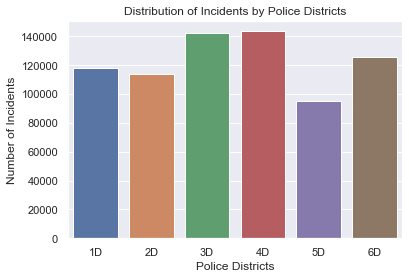

In [68]:
# Visualization: Distribution of incidents by Police Stations
fig1 = sns.countplot(dispatch.Police_District_Number,order=['1D','2D','3D','4D','5D','6D'])
plt.title('Distribution of Incidents by Police Districts')
plt.xlabel("Police Districts")
plt.ylabel("Number of Incidents")

### Insight #2: Distribution of Incidents by Priority Levels and Police Stations

Text(0.5, 1, 'Distributions of Incidents by Priority Levels and Police Districts')

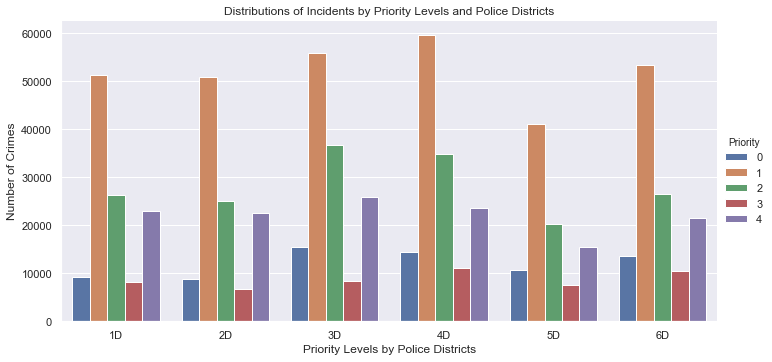

In [69]:
# Visualization: Distributions of Incidents by Priority Levels and Police Districts
fig2 = sns.catplot(x="Police_District_Number", data=dispatch, aspect=2, 
            kind='count', hue='Priority',
            order=['1D','2D','3D','4D','5D','6D'])
plt.xlabel("Priority Levels by Police Districts")
plt.ylabel("Number of Crimes")
plt.title("Distributions of Incidents by Priority Levels and Police Districts")

The bar charts show that the police districts in Silver Spring (3D) and Wheaton (4D) have the highest numbers of crime incidents with over 140,000 cases. Among the emergency calls assigned to the police stations, the majority of the cases have the priority level 1, followed by the priority level 2. 

### Insight #3: Relationship between Police District and Dispatch Lead Time

In [70]:
# Five number summary of Dispatch Lead-Time
dispatch.CallRoute_Dispatch.describe()

count    738239.000000
mean        628.105707
std        1631.178742
min           0.000000
25%          72.000000
50%         183.000000
75%         505.000000
max      346308.000000
Name: CallRoute_Dispatch, dtype: float64

In [71]:
# Show dispatch lead-time records in descending order
dispatch.sort_values(ascending = False, by = 'CallRoute_Dispatch').head(40)

,Incident_ID,Start_Time,End_Time,Priority,Close_Type,City,Longitude,Latitude,Police_District_Number,CallTime_CallRoute,Calltime_Dispatch,Calltime_Arrive,Calltime_Cleared,CallRoute_Dispatch,Dispatch_Arrive,Arrive_Cleared,Location,Latitude_1,Longitude_1,Distance
225576,P1900141647,2019-04-29,05/03/2019 06:26:13 PM,0,PEDESTRIAN STRUCK,SILVER SPRING,-77.029100,38.991860,3D,54.0,346363.0,NaN,349101.0,346308.0,NaN,NaN,POINT (-77.0291 38.9919),39.045321,-76.990709,4.227
377001,P1900377373,2019-11-14,11/18/2019 02:23:10 PM,2,STATION RESPONSE,ROCKVILLE,-77.202800,39.146070,1D,159.0,345188.0,NaN,345220.0,345028.0,NaN,NaN,POINT (-77.2028 39.1461),39.112688,-77.236059,2.915
10032,P1700615789,2017-06-26,06/30/2017 03:53:01 PM,4,FRAUDT-TRS FRAUD / DECEPTION - TELEPHONE REPOR...,KENSINGTON,-77.058500,39.037450,4D,0.0,321436.0,NaN,321788.0,321436.0,NaN,NaN,POINT (-77.0585 39.0375),39.058373,-77.048394,1.542
551785,P1700819517,2017-12-01,12/04/2017 11:01:17 AM,4,THEFT/LARCENY FROM AUTO - OCCURRED EARLIER,BETHESDA,-77.111400,38.962630,2D,187.0,238487.0,239476.0,241991.0,238299.0,989.0,2515.0,POINT (-77.1114 38.9626),38.991365,-77.097833,2.113
143719,P1700507515,2017-04-07,04/09/2017 09:41:01 PM,4,FRAUDT-TRS FRAUD / DECEPTION - TELEPHONE REPOR...,SILVER SPRING,-77.024500,38.995410,3D,224.0,194828.0,NaN,194872.0,194603.0,NaN,NaN,POINT (-77.0245 38.9954),39.045321,-76.990709,3.894
658178,P1700768811,2017-10-22,10/24/2017 04:27:18 PM,4,THEFTT - TRS THEFT/LARCENY - TELEPHONE REPORTI...,GERMANTOWN,-77.236500,39.184980,5D,71.0,192048.0,NaN,192413.0,191976.0,NaN,NaN,POINT (-77.2365 39.185),39.184388,-77.262694,1.407
610499,P1800301825,2018-08-31,09/02/2018 05:20:52 PM,4,TRAFFIC/TRANSPORTATION INCIDENT - OCCURRED EAR...,SILVER SPRING,-77.036700,38.992850,2D,70.0,180677.0,181335.0,182817.0,180606.0,658.0,1481.0,POINT (-77.0367 38.9928),38.991365,-77.097833,3.293
40624,P1800101696,2018-03-26,03/28/2018 04:22:51 PM,1,"SUSPICIOUS CIRC, PERSONS, VEHICLE",SILVER SPRING,-77.021300,39.042330,4D,178.0,179965.0,185306.0,185675.0,179787.0,5341.0,368.0,POINT (-77.0213 39.0423),39.058373,-77.048394,1.830
462524,P1800410086,2018-11-27,11/29/2018 04:27:22 PM,3,ANIMAL MISC,GAITHERSBURG,-77.226100,39.132430,6D,295.0,170894.0,170903.0,171682.0,170598.0,9.0,779.0,POINT (-77.2261 39.1324),39.149944,-77.234087,1.282
429676,P1700831462,2017-12-11,12/12/2017 05:29:49 PM,2,FRAUD/DECEPTION,GAITHERSBURG,-77.161500,39.151230,6D,1771.0,98398.0,98848.0,99947.0,96626.0,450.0,1098.0,POINT (-77.1615 39.1512),39.149944,-77.234087,3.900


In [72]:
# Show dispatch lead-time records that is higher than the 1.5 IQR
dispatch[dispatch.CallRoute_Dispatch > 724.5]

,Incident_ID,Start_Time,End_Time,Priority,Close_Type,City,Longitude,Latitude,Police_District_Number,CallTime_CallRoute,Calltime_Dispatch,Calltime_Arrive,Calltime_Cleared,CallRoute_Dispatch,Dispatch_Arrive,Arrive_Cleared,Location,Latitude_1,Longitude_1,Distance
2,P1900274361,2019-08-18,08/18/2019 08:00:37 PM,4,THEFT/LARCENY - OCCURRED EARLIER,ROCKVILLE,-77.092500,39.089230,4D,249.0,1708.0,7597.0,8177.0,1458.0,5889.0,579.0,POINT (-77.0925 39.0892),39.058373,-77.048394,3.187
5,P1700500499,2017-04-02,04/02/2017 05:20:54 PM,4,FRAUDT-TRS FRAUD / DECEPTION - TELEPHONE REPOR...,SILVER SPRING,-77.075300,39.048550,4D,55.0,904.0,NaN,1581.0,849.0,NaN,NaN,POINT (-77.0753 39.0485),39.058373,-77.048394,1.598
9,P1700501851,2017-04-03,04/03/2017 04:39:51 PM,1,RESCUE WITH FRS,SILVER SPRING,-77.052200,39.041640,4D,185.0,1108.0,1294.0,1916.0,923.0,185.0,621.0,POINT (-77.0522 39.0416),39.058373,-77.048394,1.172
27,P1900170222,2019-05-22,05/22/2019 04:47:11 PM,4,THEFTT - TRS THEFT/LARCENY - TELEPHONE REPORTI...,KENSINGTON,-77.070500,39.039560,4D,99.0,979.0,NaN,1304.0,879.0,NaN,NaN,POINT (-77.0705 39.0396),39.058373,-77.048394,1.760
30,P1900185220,2019-06-03,06/03/2019 06:07:05 PM,4,FRAUDT-TRS FRAUD / DECEPTION - TELEPHONE REPOR...,SILVER SPRING,-77.024800,39.026580,4D,143.0,2253.0,NaN,4616.0,2109.0,NaN,NaN,POINT (-77.0248 39.0266),39.058373,-77.048394,2.534
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
738229,P1700507971,2017-04-07,04/07/2017 10:51:00 PM,1,"BOMB DEVICE FOUND, SUSP PACKAGE, CONTAMINATION",RUNNING BROOK ACRES,-77.268560,39.230236,5D,116.0,1300.0,1662.0,1830.0,1183.0,362.0,168.0,POINT (-77.2686 39.2302),39.184388,-77.262694,3.178
738232,P1700517923,2017-04-15,04/15/2017 01:03:48 PM,2,TRAFFIC/TRANSPORTATION INCIDENT,MONTGOMERY COUNTY,-77.245553,39.202353,5D,98.0,835.0,1288.0,2548.0,737.0,453.0,1260.0,POINT (-77.2456 39.2024),39.184388,-77.262694,1.544
738234,P1700521558,2017-04-18,04/18/2017 01:30:55 PM,2,TRAFFIC/TRANSPORTATION INCIDENT,GERMANTOWN,-77.270805,39.182886,5D,143.0,1956.0,4485.0,5394.0,1813.0,2529.0,909.0,POINT (-77.2708 39.1829),39.184388,-77.262694,0.448
738235,P1700521919,2017-04-18,04/18/2017 05:14:06 PM,2,TRAFFIC/TRANSPORTATION INCIDENT,BRANDERMILL,-77.232295,39.184378,5D,120.0,944.0,1876.0,3421.0,823.0,932.0,1544.0,POINT (-77.2323 39.1844),39.184388,-77.262694,1.632


In [73]:
# Relationship between Police District and Dispatch Lead Time - With outliers
# One-way ANOVA
# H0: There is no relationship between Police Districts and Response Time
# H1: There is relationship between Police Districs and Response Time

group_1 = dispatch[dispatch.Police_District_Number == '1D']
group_2 = dispatch[dispatch.Police_District_Number == '2D']
group_3 = dispatch[dispatch.Police_District_Number == '3D']
group_4 = dispatch[dispatch.Police_District_Number == '4D']
group_5 = dispatch[dispatch.Police_District_Number == '5D']
group_6 = dispatch[dispatch.Police_District_Number == '6D']

fvalue, pvalue = stats.f_oneway(group_1['CallRoute_Dispatch'], 
                                group_2['CallRoute_Dispatch'], 
                                group_3['CallRoute_Dispatch'], 
                                group_4['CallRoute_Dispatch'],
                                group_5['CallRoute_Dispatch'], 
                                group_6['CallRoute_Dispatch'])
fvalue, pvalue

(406.47787213935914, 0.0)

The P-value from ANOVA analysis is significant (p < 0.05); therefore, we conclude that there is a relationship between Police Districts and Dispatch Lead-time.

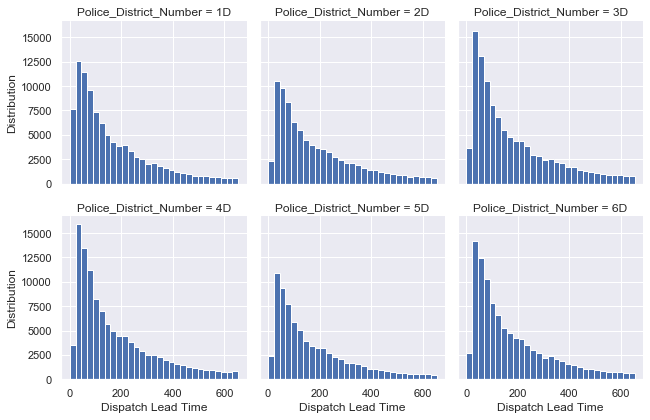

In [74]:
# Visualization: Distribution of Dispatch lead Time by Police Districts - Without outliers
dispatch_no_outliers = dispatch[dispatch['CallRoute_Dispatch'] <= 724.5]
fig3 = sns.FacetGrid(dispatch_no_outliers, 
                     col="Police_District_Number", 
                     col_wrap=3,
                     col_order=['1D','2D','3D','4D','5D','6D'],
                     margin_titles=True)
fig3.map(plt.hist, "CallRoute_Dispatch", bins= np.linspace(0, 654, 30))
fig3.set_axis_labels("Dispatch Lead Time", "Distribution")
#fig3.set_titles("Distribution of Dispatch lead Time by Police Districts")


In [75]:
# Relationship between Police District and Dispatch Lead Time - Without outliers
# One-way ANOVA without outliers
# H0: There is no relationship between Police Districts and Response Time
# H1: There is relationship between Police Districs and Response Time
dispatch_no_outliers = dispatch[dispatch['CallRoute_Dispatch'] <= 654]

group_1 = dispatch_no_outliers[dispatch_no_outliers.Police_District_Number == '1D']
group_2 = dispatch_no_outliers[dispatch_no_outliers.Police_District_Number == '2D']
group_3 = dispatch_no_outliers[dispatch_no_outliers.Police_District_Number == '3D']
group_4 = dispatch_no_outliers[dispatch_no_outliers.Police_District_Number == '4D']
group_5 = dispatch_no_outliers[dispatch_no_outliers.Police_District_Number == '5D']
group_6 = dispatch_no_outliers[dispatch_no_outliers.Police_District_Number == '6D']

fvalue, pvalue = stats.f_oneway(group_1['CallRoute_Dispatch'], 
                                group_2['CallRoute_Dispatch'], 
                                group_3['CallRoute_Dispatch'], 
                                group_4['CallRoute_Dispatch'],
                                group_5['CallRoute_Dispatch'], 
                                group_6['CallRoute_Dispatch'])
fvalue, pvalue

(219.2581892713637, 1.4181464501482835e-234)

The “CallRoute_Dispatch” shows the time between the data entry to the first unit dispatched as the dispatch lead-time. The five number summary shows that the 75% quantile is 7 minutes. The 1.5 IQR concept helps identify the outliers. The one-way ANOVA test is not much affected if the data distribution is skewed unless the group sizes are small. Since the distributions of the groups are similar, we can still apply the ANOVA method despite the fact that they are not normal. Both ANOVA tests (with and without outliers) have the p-values lower than 0.05; therefore, we conclude that there is a relationship between police districts and dispatch lead-time while the expected result is that the dispatch lead-time should be equal among the police districts. 

### Insight #4: Relationship between Police District and Distance

Text(0, 0.5, 'Distance')

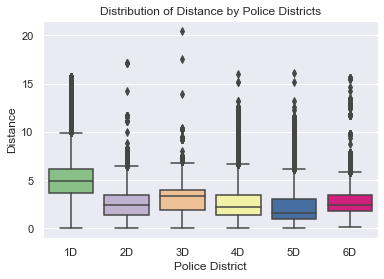

In [76]:
# Correlation between Police District and Distance - Boxplots
palette = sns.color_palette('Accent')
fig6 = sns.boxplot("Police_District_Number","Distance", 
                   data = dispatch, 
                   palette = palette,
                   order=['1D','2D','3D','4D','5D','6D'])
plt.title('Distribution of Distance by Police Districts')
plt.xlabel('Police District')
plt.ylabel('Distance')

In [77]:
# Relationship between Police District and Dispatch Lead Time - Without outliers
# One-way ANOVA without outliers
# H0: There is no relationship between Police Districts and Response Time
# H1: There is relationship between Police Districs and Response Time
dispatch_no_outliers = dispatch[dispatch['CallRoute_Dispatch'] <= 654]

group_1 = dispatch_no_outliers[dispatch_no_outliers.Police_District_Number == '1D']
group_2 = dispatch_no_outliers[dispatch_no_outliers.Police_District_Number == '2D']
group_3 = dispatch_no_outliers[dispatch_no_outliers.Police_District_Number == '3D']
group_4 = dispatch_no_outliers[dispatch_no_outliers.Police_District_Number == '4D']
group_5 = dispatch_no_outliers[dispatch_no_outliers.Police_District_Number == '5D']
group_6 = dispatch_no_outliers[dispatch_no_outliers.Police_District_Number == '6D']

fvalue, pvalue = stats.f_oneway(group_1['CallRoute_Dispatch'], 
                                group_2['CallRoute_Dispatch'], 
                                group_3['CallRoute_Dispatch'], 
                                group_4['CallRoute_Dispatch'],
                                group_5['CallRoute_Dispatch'], 
                                group_6['CallRoute_Dispatch'])
fvalue, pvalue

(219.2581892713637, 1.4181464501482835e-234)

The report shows that the ANOVA test has the p-value significantly below 0.05; therefore, we conclude that there is a relationship between police districts and the distance between the stations and the incident locations. The result is the opposite to the expected result that the travel distances should be equal among police districts. The Rockville district (1D) has a higher median of 5 miles compared to the other districts.

# Final Data Products

The first data product provides the time-series forecast for the number of calls received in 2021 using the SARIMAX method. The second data product presents the police dispatched incidents mapping on Tableau Public and the concept of the center of gravity to suggest the optimal location of the current and additional police stations.

## Data Product 1: Time-series Forecasting

In [78]:
# Show number of incidents based on Start_Time
daily_summary = dispatch.groupby('Start_Time')[['Incident_ID']].agg('count').reset_index()
daily_summary

,Start_Time,Incident_ID
0,2017-04-02,34
1,2017-04-03,32
2,2017-04-04,58
3,2017-04-05,43
4,2017-04-06,68
...,...,...
1349,2020-12-11,525
1350,2020-12-12,482
1351,2020-12-13,446
1352,2020-12-14,448


In [79]:
# Show number of incidents by months and years
daily_summary.Start_Time = pd.to_datetime(daily_summary.Start_Time)
monthly_summary = daily_summary.groupby([daily_summary.Start_Time.dt.year, daily_summary.Start_Time.dt.month])[['Incident_ID']].agg('sum')
monthly_summary

Incident_ID
Start_Time Start_Time             
2017       4                 14113
           5                 18736
           6                 19403
           7                 18500
           8                 18232
           9                 17562
           10                17999
           11                16986
           12                16665
2018       1                 16315
           2                 14358
           3                 16127
           4                 16140
           5                 18515
           6                 18504
           7                 18740
           8                 18188
           9                 17506
           10                18503
           11                16742
           12                16970
2019       1                 16359
           2                 14852
           3                 16509
           4                 17029
           5                 18655
           6                 17467
           7                 17778
           8                 17504
           9                 16521
           10                17051
           11                16042
           12                16267
2020       1                 15817
           2                 14954
           3                 15089
           4                 12807
           5                 14853
           6                 14850
           7                 15778
           8                 15667
           9                 15114
           10                15365
           11                14548
           12                 6559

In [80]:
# Change the column names of monthly_summary
monthly_summary.index = monthly_summary.index.set_names(['Year', 'Month'])
monthly_summary.reset_index(inplace=True)

In [81]:
# Monthly number of incidents from 2017 to 2020
monthly_summary

,Year,Month,Incident_ID
0,2017,4,14113
1,2017,5,18736
2,2017,6,19403
3,2017,7,18500
4,2017,8,18232
5,2017,9,17562
6,2017,10,17999
7,2017,11,16986
8,2017,12,16665
9,2018,1,16315


Text(0.5, 1.0, 'Distribution of Incidents by Years')

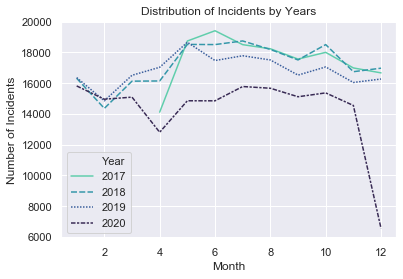

In [82]:
# Visualization: Distribution of Incidents by Months and Years
palette = sns.color_palette("mako_r", 4)
sns.lineplot(data = monthly_summary,
             x = "Month",
             y = "Incident_ID",
             hue = "Year",
             style = "Year",
             palette=palette)
plt.xlabel("Month")
plt.ylabel("Number of Incidents")
plt.title("Distribution of Incidents by Years")

The line graph shows that the data from 2017 to 2019 have similar patterns while the number of calls in 2020 is significantly lower than the previous years. The dramatic reduction in April 2020 implies the impacts of the pandemic due to the stay-at-home order that limits gatherings and business operations in March 2020. 

In [83]:
# Set Start_Time as index
daily_summary = daily_summary.set_index('Start_Time')
daily_summary

,Incident_ID
Start_Time,
2017-04-02,34
2017-04-03,32
2017-04-04,58
2017-04-05,43
2017-04-06,68
...,...
2020-12-11,525
2020-12-12,482
2020-12-13,446


Originally, the analysis uses both SARIMAX method and Facebook Prophet library to conduct the time-series data. The report compares the root mean square errors of the forecasts to evaluate the performance of each method. The data product is the result of the SARIMAX model selection. Before conducting the forecast, the model check if the data is stationary. De-trending and de-seasonalizing applies to resolve the lack of stationarity.

### Scenario 1: The forecast excludes the data of the year 2020 

In [84]:
# Select the monthly number of incidents in 2017, 2018, and 2019
daily_summary = daily_summary['Incident_ID'].resample('MS').sum()
scenario_1 = daily_summary['2017':'2019']
scenario_1.tail()

Start_Time
2019-08-01    17504
2019-09-01    16521
2019-10-01    17051
2019-11-01    16042
2019-12-01    16267
Freq: MS, Name: Incident_ID, dtype: int64

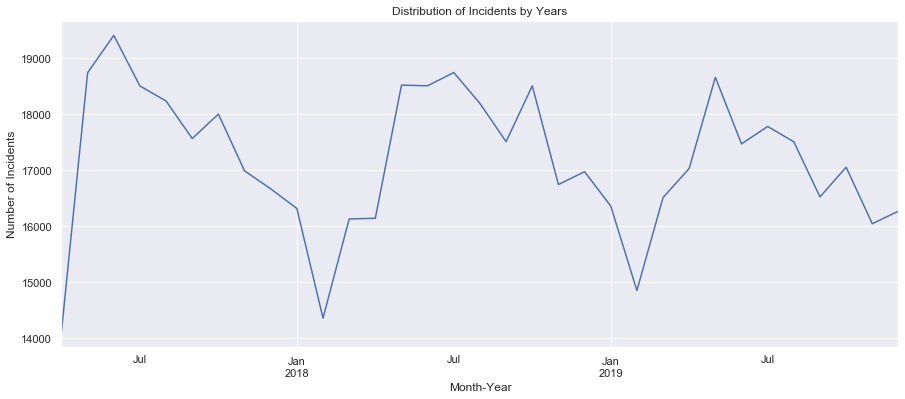

In [85]:
# Line chart showing the monthly number of incidents from 2017 to 2019
scenario_1.plot(figsize=(15, 6))
plt.xlabel("Month-Year")
plt.ylabel("Number of Incidents")
plt.title("Distribution of Incidents by Years")
plt.show()

#### Decompose the time series

(array([736420., 736511., 736603., 736695., 736785., 736876., 736968.,
        737060., 737150., 737241., 737333.]),
 <a list of 11 Text xticklabel objects>)

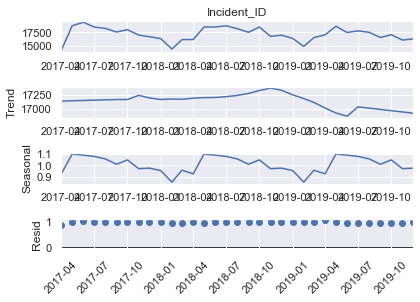

In [86]:
# Multiplicative Decomposition
from statsmodels.tsa.seasonal import seasonal_decompose
result_mul_1 = seasonal_decompose(scenario_1, model = 'multiplicative', extrapolate_trend = 'freq')
result_mul_1.plot()
plt.xticks(rotation=45)

(array([736420., 736511., 736603., 736695., 736785., 736876., 736968.,
        737060., 737150., 737241., 737333.]),
 <a list of 11 Text xticklabel objects>)

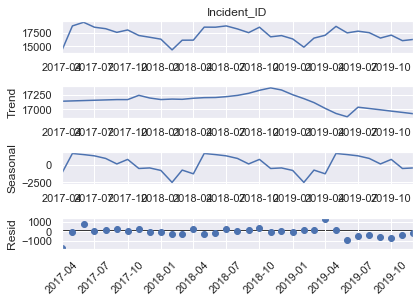

In [87]:
# Additive Decomposition
from statsmodels.tsa.seasonal import seasonal_decompose
result_add_1 = seasonal_decompose(scenario_1, model = 'additive', extrapolate_trend = 'freq')
result_add_1.plot()
plt.xticks(rotation=45)

The residuals fluctuate more in the additive decomposition graph; therefore, the additive model is selected.

#### Check for Stationarity

In [88]:
# Augmented Dickey-Fuller Test
from statsmodels.tsa.stattools import adfuller

def ADF_test(timeseries, dataDesc):
    print(' > Is the {} stationary ?'.format(dataDesc))
    dftest = adfuller(timeseries.dropna(), autolag='AIC')
    print('Test statistic = {:.3f}'.format(dftest[0]))
    print('P-value = {:.3f}'.format(dftest[1]))
    print('Critical values :')
    for k, v in dftest[4].items():
        print('\t{}: {} - The data is {} stationary with {}% confidence'.format(k, v, 'not' if v<dftest[0] else '', 100-int(k[:-1])))

In [89]:
ADF_test(scenario_1,'raw data')

 > Is the raw data stationary ?
Test statistic = -0.775
P-value = 0.826
Critical values :
	1%: -3.7529275211638033 - The data is not stationary with 99% confidence
	5%: -2.998499866852963 - The data is not stationary with 95% confidence
	10%: -2.6389669754253307 - The data is not stationary with 90% confidence


#### SARIMAX Method

In [90]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [91]:
# Find the optimal set of parameters that yealds the best performace for the model. 
# AIC measures how well a model fits the data while taking into account the overall complexity of the model.
warnings.filterwarnings("ignore")
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(scenario_1,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results_1 = mod.fit()
            
            print('ARIMA{}x{} - AIC:{}'.format(param, param_seasonal, results_1.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12) - AIC:717.3975415547102
ARIMA(0, 0, 0)x(0, 0, 1, 12) - AIC:426.70158190783565
ARIMA(0, 0, 0)x(0, 1, 0, 12) - AIC:319.22945814748107
ARIMA(0, 0, 0)x(0, 1, 1, 12) - AIC:123.98908610462713
ARIMA(0, 0, 0)x(1, 0, 0, 12) - AIC:342.77291577790345
ARIMA(0, 0, 0)x(1, 0, 1, 12) - AIC:312.69423146249085
ARIMA(0, 0, 0)x(1, 1, 0, 12) - AIC:151.30051081958192
ARIMA(0, 0, 0)x(1, 1, 1, 12) - AIC:125.32517284305973
ARIMA(0, 0, 1)x(0, 0, 0, 12) - AIC:674.9607028651465
ARIMA(0, 0, 1)x(0, 0, 1, 12) - AIC:413.3884264721092
ARIMA(0, 0, 1)x(0, 1, 0, 12) - AIC:299.55818724111685
ARIMA(0, 0, 1)x(0, 1, 1, 12) - AIC:99.66002032096088
ARIMA(0, 0, 1)x(1, 0, 0, 12) - AIC:329.2896738907056
ARIMA(0, 0, 1)x(1, 0, 1, 12) - AIC:297.32450127114356
ARIMA(0, 0, 1)x(1, 1, 0, 12) - AIC:146.28250945081632
ARIMA(0, 0, 1)x(1, 1, 1, 12) - AIC:100.0101711260733
ARIMA(0, 1, 0)x(0, 0, 0, 12) - AIC:520.1943207389236
ARIMA(0, 1, 0)x(0, 0, 1, 12) - AIC:306.76264987659164
ARIMA(0, 1, 0)x(0, 1, 0, 12) - AIC:

In [92]:
# Fit the model
mod = sm.tsa.statespace.SARIMAX(scenario_1,
                                order=(0, 1, 1),
                                seasonal_order=(0, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results_1 = mod.fit()

In [93]:
# Predict the monthly number of crimes in 2019
pred_1 = results_1.get_prediction(start=pd.to_datetime('2019-01-01'), dynamic=False)
pred_ci_1 = pred_1.conf_int()
pred_ci_1

,lower Incident_ID,upper Incident_ID
Start_Time,,
2019-01-01,15913.464207,17041.098927
2019-02-01,13940.998747,15068.633306
2019-03-01,15773.483338,16900.944850
2019-04-01,16134.313871,17260.020271
2019-05-01,18663.958836,19767.216902
2019-06-01,18674.597545,19670.833644
2019-07-01,17302.454592,18285.319536
2019-08-01,16885.576421,17866.376743
2019-09-01,16296.241192,17276.714699


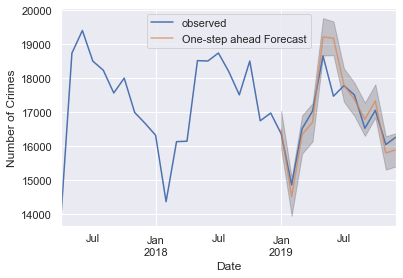

In [94]:
# Validate the predictions
ax = scenario_1['2017':].plot(label='observed')
pred_1.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7)

ax.fill_between(pred_ci_1.index,
                pred_ci_1.iloc[:, 0],
                pred_ci_1.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('Number of Crimes')
plt.legend()

plt.show()

In [95]:
# Compute the mean square error
y_forecasted_1 = pred_1.predicted_mean
y_truth_1 = scenario_1['2019-01-01':]

mse_1 = ((y_forecasted_1 - y_truth_1) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse_1, 2)))

The Mean Squared Error of our forecasts is 322113.39


In [96]:
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse_1), 2)))

The Root Mean Squared Error of our forecasts is 567.55


The root mean square error of the first scenario is 567.55. While the number of incidents of each month is normally over 10,000 so the RMSE is acceptable.

In [97]:
# Produce forecasts for 2020 and 2021
pred_uc_1 = results_1.get_forecast(steps=24)
pred_ci_1 = pred_uc_1.conf_int()

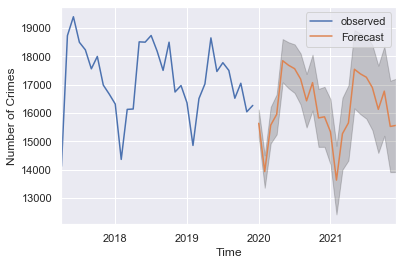

In [98]:
# Visualize forecasts for 2020 and 2021
ax = scenario_1['2017':].plot(label='observed')
pred_uc_1.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci_1.index,
                pred_ci_1.iloc[:, 0],
                pred_ci_1.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Time')
ax.set_ylabel('Number of Crimes')
plt.legend()
plt.show()

### Scenario 2: The forecast includes the data of the year 2020 

In [99]:
# Select the monthly number of incidents 2017-2020
scenario_2 = daily_summary['2017':'2020']
scenario_2.tail()

Start_Time
2020-08-01    15667
2020-09-01    15114
2020-10-01    15365
2020-11-01    14548
2020-12-01     6559
Freq: MS, Name: Incident_ID, dtype: int64

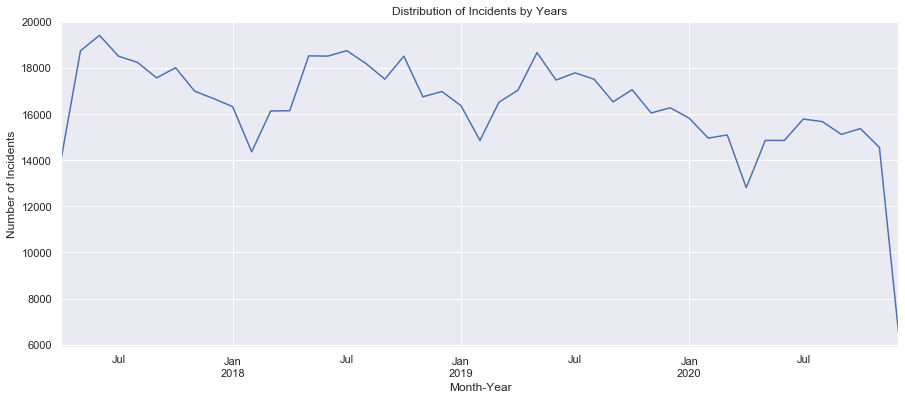

In [100]:
# Line chart showing the monthly number of incidents 2017-2020
scenario_2.plot(figsize=(15, 6))
plt.xlabel("Month-Year")
plt.ylabel("Number of Incidents")
plt.title("Distribution of Incidents by Years")
plt.show()

#### Decompose the time series

(array([736450., 736573., 736695., 736815., 736938., 737060., 737180.,
        737303., 737425., 737546., 737669.]),
 <a list of 11 Text xticklabel objects>)

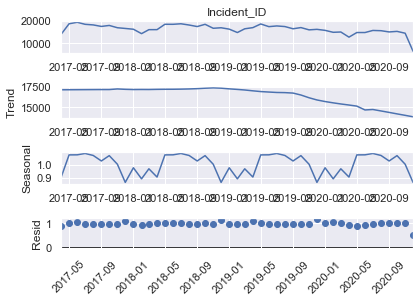

In [101]:
# Multiplicative Decomposition
from statsmodels.tsa.seasonal import seasonal_decompose
result_mul_2 = seasonal_decompose(scenario_2, model = 'multiplicative', extrapolate_trend = 'freq')
result_mul_2.plot()
plt.xticks(rotation=45)

(array([736450., 736573., 736695., 736815., 736938., 737060., 737180.,
        737303., 737425., 737546., 737669.]),
 <a list of 11 Text xticklabel objects>)

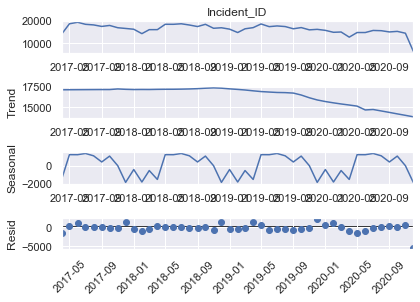

In [102]:
# Additive Decomposition
from statsmodels.tsa.seasonal import seasonal_decompose
result_add_2 = seasonal_decompose(scenario_2, model = 'additive', extrapolate_trend = 'freq')
result_add_2.plot()
plt.xticks(rotation=45)

#### Check for Stationarity

In [103]:
# Augmented Dickey-Fuller Test
from statsmodels.tsa.stattools import adfuller

def ADF_test(timeseries, dataDesc):
    print(' > Is the {} stationary ?'.format(dataDesc))
    dftest = adfuller(timeseries.dropna(), autolag='AIC')
    print('Test statistic = {:.3f}'.format(dftest[0]))
    print('P-value = {:.3f}'.format(dftest[1]))
    print('Critical values :')
    for k, v in dftest[4].items():
        print('\t{}: {} - The data is {} stationary with {}% confidence'.format(k, v, 'not' if v<dftest[0] else '', 100-int(k[:-1])))

In [104]:
ADF_test(scenario_2,'raw data')

 > Is the raw data stationary ?
Test statistic = -1.026
P-value = 0.744
Critical values :
	1%: -3.5885733964124715 - The data is not stationary with 99% confidence
	5%: -2.929885661157025 - The data is not stationary with 95% confidence
	10%: -2.6031845661157025 - The data is not stationary with 90% confidence


#### Make the Data Stationary

In [105]:
# Detrend using statmodels: Subtracting the Trend Component
from statsmodels.tsa.seasonal import seasonal_decompose
detrend = scenario_2.values - result_add_2.trend

In [106]:
ADF_test(detrend,'raw data')

 > Is the raw data stationary ?
Test statistic = -3.365
P-value = 0.012
Critical values :
	1%: -3.626651907578875 - The data is not stationary with 99% confidence
	5%: -2.9459512825788754 - The data is  stationary with 95% confidence
	10%: -2.6116707716049383 - The data is  stationary with 90% confidence


In [107]:
# The data is not stationary after detrending. Proceed to deseasonalize
deseasonalized = detrend.values - result_add_2.seasonal
deseasonalized

Start_Time
2017-04-01   -1498.786159
2017-05-01     399.570630
2017-06-01    1065.344086
2017-07-01      19.687484
2017-08-01       5.237163
2017-09-01       3.911843
2017-10-01    -202.581346
2017-11-01    -239.294706
2017-12-01    1318.335685
2018-01-01    -414.570238
2018-02-01   -1010.834127
2018-03-01    -494.292460
2018-04-01     475.955440
2018-05-01     121.225399
2018-06-01     112.203692
2018-07-01     196.751926
2018-08-01    -118.368557
2018-09-01    -162.447374
2018-10-01     137.835320
2018-11-01    -614.503039
2018-12-01    1482.835685
2019-01-01    -455.236904
2019-02-01    -524.750793
2019-03-01     -54.834127
2019-04-01    1542.622106
2019-05-01     539.392066
2019-06-01    -585.629642
2019-07-01    -359.664740
2019-08-01    -356.035224
2019-09-01    -609.697374
2019-10-01    -488.373013
2019-11-01    -111.503039
2019-12-01    2212.919018
2020-01-01     544.929762
2020-02-01    1210.707540
2020-03-01     224.249207
2020-04-01    -952.961227
2020-05-01   -1493.357934
2

In [108]:
ADF_test(deseasonalized,'raw data')

 > Is the raw data stationary ?
Test statistic = -4.179
P-value = 0.001
Critical values :
	1%: -3.5885733964124715 - The data is  stationary with 99% confidence
	5%: -2.929885661157025 - The data is  stationary with 95% confidence
	10%: -2.6031845661157025 - The data is  stationary with 90% confidence


#### SARIMAX Method

In [109]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [110]:
# Find the optimal set of parameters that yealds the best performace for the model
warnings.filterwarnings("ignore")
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(deseasonalized,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results_2 = mod.fit()
            
            print('ARIMA{}x{} - AIC:{}'.format(param, param_seasonal, results_2.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12) - AIC:742.8920954840471
ARIMA(0, 0, 0)x(0, 0, 1, 12) - AIC:1397.2537562247812
ARIMA(0, 0, 0)x(0, 1, 0, 12) - AIC:564.4257909542275
ARIMA(0, 0, 0)x(0, 1, 1, 12) - AIC:358.14548268364746
ARIMA(0, 0, 0)x(1, 0, 0, 12) - AIC:563.4889164704803
ARIMA(0, 0, 0)x(1, 0, 1, 12) - AIC:1300.8251832556643
ARIMA(0, 0, 0)x(1, 1, 0, 12) - AIC:380.35721844443674
ARIMA(0, 0, 0)x(1, 1, 1, 12) - AIC:359.5987919137055
ARIMA(0, 0, 1)x(0, 0, 0, 12) - AIC:728.7130914011326
ARIMA(0, 0, 1)x(0, 0, 1, 12) - AIC:2640.671149621875
ARIMA(0, 0, 1)x(0, 1, 0, 12) - AIC:548.3940469403753
ARIMA(0, 0, 1)x(0, 1, 1, 12) - AIC:343.3177794122534
ARIMA(0, 0, 1)x(1, 0, 0, 12) - AIC:565.4865911433211
ARIMA(0, 0, 1)x(1, 0, 1, 12) - AIC:756383454172.8304
ARIMA(0, 0, 1)x(1, 1, 0, 12) - AIC:382.1028486222864
ARIMA(0, 0, 1)x(1, 1, 1, 12) - AIC:344.77596345012427
ARIMA(0, 1, 0)x(0, 0, 0, 12) - AIC:739.7473882369683
ARIMA(0, 1, 0)x(0, 0, 1, 12) - AIC:1303.831516733512
ARIMA(0, 1, 0)x(0, 1, 0, 12) - AIC:551.19

In [111]:
# Fit the model
mod = sm.tsa.statespace.SARIMAX(deseasonalized,
                                order=(0, 1, 1),
                                seasonal_order=(0, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results_2 = mod.fit()

In [112]:
# Predict the monthly number of crimes in 2020
pred_2 = results_2.get_prediction(start=pd.to_datetime('2020-01-01'), dynamic=False)
pred_ci_2 = pred_2.conf_int()
pred_ci_2

,lower seasonal,upper seasonal
Start_Time,,
2020-01-01,-3739.326396,4438.973540
2020-02-01,-3980.607541,4197.332616
2020-03-01,-3372.370779,4793.283903
2020-04-01,-4129.100867,3991.576179
2020-05-01,-3828.568727,4443.686004
2020-06-01,-4003.770864,4126.905642
2020-07-01,-4232.868779,3865.607604
2020-08-01,-4304.349054,3779.314570
2020-09-01,-4287.078491,3786.777741


In [113]:
result_add_2.trend[33:]

Start_Time
2020-01-01    15711.083333
2020-02-01    15551.208333
2020-03-01    15416.041667
2020-04-01    15287.166667
2020-05-01    15154.666667
2020-06-01    14687.916667
2020-07-01    14743.863102
2020-08-01    14566.217997
2020-09-01    14388.572892
2020-10-01    14210.927787
2020-11-01    14033.282683
2020-12-01    13855.637578
Freq: MS, Name: trend, dtype: float64

In [114]:
result_add_2.seasonal[33:]

Start_Time
2020-01-01    -439.013096
2020-02-01   -1807.915873
2020-03-01    -551.290873
2020-04-01   -1527.205440
2020-05-01    1191.691268
2020-06-01    1187.171308
2020-07-01    1324.081407
2020-08-01    1064.785224
2020-09-01     390.364041
2020-10-01    1034.123013
2020-11-01     -17.413627
2020-12-01   -1849.377351
Freq: MS, Name: seasonal, dtype: float64

In [115]:
# Add trend and seasonality back to 2020 predictions
scenario_2_pred = pred_2.predicted_mean.values + result_add_2.seasonal[33:] + result_add_2.trend[33:]

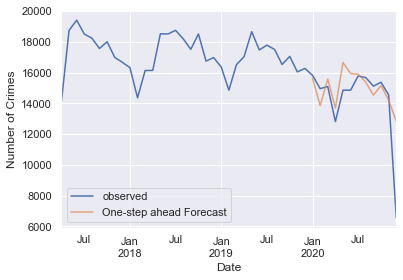

In [116]:
# Validate the predictions
ax = scenario_2['2017':].plot(label='observed')
scenario_2_pred.plot(ax=ax, label='One-step ahead Forecast', alpha=.7)
ax.set_xlabel('Date')
ax.set_ylabel('Number of Crimes')
plt.legend()

plt.show()

In [117]:
# Compute the mean square error
y_forecasted_2 = scenario_2_pred
y_truth_2 = scenario_2['2020-01-01':]

mse_2 = ((y_forecasted_2 - y_truth_2) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse_2, 2)))

The Mean Squared Error of our forecasts is 3894121.54


In [118]:
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse_2), 2)))

The Root Mean Squared Error of our forecasts is 1973.35


In [119]:
# Produce forecasts for 2021
pred_uc_2 = results_2.get_forecast(steps=12)
pred_ci_2 = pred_uc_2.conf_int()

The root mean square error of the first scenario is 1,973.35. The RMSE of the second scenario is higher than that of the first scenario due to the unique pattern of the data 2020. Furthermore, the cut-off time of the analysis is mid-December; therefore, the forecast may be affected by the insufficient data.

In [120]:
# In order to add the trend and seasonality to the 2021 forecast, 
def getSlope(x1, y1, x2, y2):
    slope = (y2-y1)/(x2-x1)
    return slope

getSlope(0, 14293.70833333, 24, 10157.54953380)

-172.33994998041666

In [121]:
trend_pred = []
for x in range (25, 37):
    y = -172.33994998041666 * x + 14293.70833333
    trend_pred.append(y)
trend_pred

[9985.209583819582,
 9812.869633839167,
 9640.52968385875,
 9468.189733878333,
 9295.849783897916,
 9123.5098339175,
 8951.169883937084,
 8778.829933956666,
 8606.489983976251,
 8434.150033995833,
 8261.810084015417,
 8089.470134035]

In [122]:
scenario_2_fc = pred_uc_2.predicted_mean + result_add_2.seasonal[33:].values + trend_pred

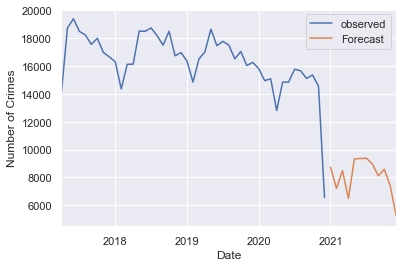

In [123]:
ax = scenario_2['2017':].plot(label='observed')
scenario_2_fc.plot(ax=ax, label='Forecast')
ax.set_xlabel('Date')
ax.set_ylabel('Number of Crimes')
plt.legend()
plt.show()

## Product 2:  Suggesting Optimal Location for Additional Police District

On Tableau Public, the latitude and longitude coordinates of the police stations and incident locations are used to create the origin-destination map showing the distribution of the dispatched incidents in the six police districts. The visualization supports the results of the one-way ANOVA test regarding the relationship between the police districts and travel distance. The Rockville station (1D) is responsible for the larger area compared to the other stations, and the descriptive statistics show that the Rockville station has longer travel distances. The suggestions are either relocating the 1D station or having an additional station near Dickerson and Poolesville cities. 

Link to Tableau mapping: https://public.tableau.com/profile/minh.tu.bui7265#!/vizhome/PoliceDispatchedIncidentMapping/Sheet1?publish=yes

In [124]:
# Show the records that 1D district was in charge of
scen_1 = dispatch[dispatch.Police_District_Number == "1D"]

In [125]:
scen_1.reset_index()

,index,Incident_ID,Start_Time,End_Time,Priority,Close_Type,City,Longitude,Latitude,Police_District_Number,...,Calltime_Dispatch,Calltime_Arrive,Calltime_Cleared,CallRoute_Dispatch,Dispatch_Arrive,Arrive_Cleared,Location,Latitude_1,Longitude_1,Distance
0,285943,P1700500127,2017-04-02,04/02/2017 04:03:37 PM,4,MIS - MISC ON PATROL,ROCKVILLE,-77.152900,39.084230,1D,...,218.0,267.0,18846.0,17.0,48.0,18579.0,POINT (-77.1529 39.0842),39.112688,-77.236059,4.882
1,285944,P1700500197,2017-04-02,04/02/2017 12:13:15 PM,4,MIS - MISC ON PATROL,ROCKVILLE,-77.152900,39.084230,1D,...,306.0,NaN,556.0,248.0,NaN,NaN,POINT (-77.1529 39.0842),39.112688,-77.236059,4.882
2,285945,P1700500475,2017-04-02,04/02/2017 06:59:51 PM,2,NON-PRIORITY RESPONSE TRANSPORT,POTOMAC,-77.161800,39.067040,1D,...,2085.0,4612.0,9423.0,2085.0,2527.0,4811.0,POINT (-77.1618 39.067),39.112688,-77.236059,5.085
3,285946,P1700500632,2017-04-02,04/02/2017 08:35:29 PM,2,THEFT/LARCENY,POTOMAC,-77.176500,39.065350,1D,...,3300.0,4237.0,5464.0,2976.0,936.0,1226.0,POINT (-77.1765 39.0654),39.112688,-77.236059,4.573
4,285947,P1900059639,2019-02-21,02/21/2019 06:45:47 PM,4,FRAUDT-TRS FRAUD / DECEPTION - TELEPHONE REPOR...,ROCKVILLE,-77.153300,39.066180,1D,...,262.0,NaN,3328.0,19.0,NaN,NaN,POINT (-77.1533 39.0662),39.112688,-77.236059,5.485
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117823,403767,P1700554839,2017-05-13,05/13/2017 03:43:23 PM,2,TRAFFIC/TRANSPORTATION INCIDENT,ROCKVILLE,-77.128226,39.066930,1D,...,279.0,855.0,1635.0,162.0,575.0,780.0,POINT (-77.1282 39.0669),39.112688,-77.236059,6.601
117824,403768,P1700555731,2017-05-14,05/14/2017 11:16:53 AM,1,ANIMAL RESCUE,DARNESTOWN,-77.261474,39.117714,1D,...,234.0,2434.0,2539.0,180.0,2200.0,105.0,POINT (-77.2615 39.1177),39.112688,-77.236059,1.409
117825,403769,P1700555765,2017-05-14,05/14/2017 11:33:16 AM,2,TRAFFIC/TRANSPORTATION INCIDENT,BEANTOWN,-77.136566,39.097736,1D,...,330.0,785.0,950.0,219.0,454.0,164.0,POINT (-77.1366 39.0977),39.112688,-77.236059,5.446
117826,403770,P1700557079,2017-05-15,05/15/2017 02:38:14 PM,0,TRAFFIC/TRANSPORTATION INCIDENT,LAKE NORMANDY ESTATES,-77.188051,39.050418,1D,...,188.0,457.0,5970.0,67.0,269.0,5512.0,POINT (-77.1881 39.0504),39.112688,-77.236059,5.011


In [126]:
# Show the number of incidents in each city 
scen_1.City.value_counts()

ROCKVILLE                  81420
POTOMAC                    15340
GAITHERSBURG                8587
DERWOOD                     6906
POOLESVILLE                 2762
GERMANTOWN                  1554
DICKERSON                    690
BOYDS                        301
BEALLSVILLE                  171
MONTGOMERY COUNTY             27
BETHESDA                      23
NORTH BETHESDA                 5
BROWNS CORNER                  4
MAPLE AVENUE DISTRICT          3
SILVER SPRING                  3
MARYLAND                       3
KING FARM                      3
FRANKLIN PARK                  2
TOBYTOWN                       2
FALLS ORCHARD                  2
OLNEY                          1
ROCKCREST                      1
BEANTOWN                       1
NORTH POTOMAC                  1
BARNESVILLE                    1
HUNGERFORD TOWNE               1
FREDERICK COUNTY               1
MONTROSE                       1
SILVER ROCK                    1
WESMOND                        1
TRAVILAH  

In [127]:
# Identify intepreted addresses in Rockville
mask3 = scen_1.City.isin(['KING FARM', 'FALLS ORCHARD', 'MONTROSE', 
                          'ROCKCREST', 'SILVER ROCK', 'HUNGERFORD TOWNE', 
                          'WESTMORE' ])

scen_1.loc[mask3, 'City'] = scen_1.loc[mask3, 'City'].replace(['KING FARM', 'FALLS ORCHARD', 'MONTROSE', 
                                                               'ROCKCREST', 'SILVER ROCK', 'HUNGERFORD TOWNE', 
                                                               'WESTMORE' ], "ROCKVILLE")

In [128]:
# Identify intepreted addresses in Darnestow
mask4 = scen_1.City.isin(['BROWNS CORNER', 'BONDBROOK', 'HIGHLANDS OF DARNESTOWN', 
                          'DEAKINS RANGE'])

scen_1.loc[mask4, 'City'] = scen_1.loc[mask4, 'City'].replace(['BROWNS CORNER', 'BONDBROOK', 'HIGHLANDS OF DARNESTOWN', 
                                                               'DEAKINS RANGE'], "DARNESTOWN")

In [129]:
# Identify intepreted addresses in Potomac
mask5 = scen_1.City.isin(['NORTH POTOMAC', 'MONTGOMERY SQUARE', 'LAKE NORMANDY ESTATES'])

scen_1.loc[mask5, 'City'] = scen_1.loc[mask5, 'City'].replace(['NORTH POTOMAC', 'MONTGOMERY SQUARE', 
                                                               'LAKE NORMANDY ESTATES'], "POTOMAC")

In [130]:
scen_1.City.value_counts()

ROCKVILLE                81430
POTOMAC                  15343
GAITHERSBURG              8587
DERWOOD                   6906
POOLESVILLE               2762
GERMANTOWN                1554
DICKERSON                  690
BOYDS                      301
BEALLSVILLE                171
MONTGOMERY COUNTY           27
BETHESDA                    23
DARNESTOWN                   8
NORTH BETHESDA               5
SILVER SPRING                3
MAPLE AVENUE DISTRICT        3
MARYLAND                     3
FRANKLIN PARK                2
TOBYTOWN                     2
OLNEY                        1
BEANTOWN                     1
WESMOND                      1
FREDERICK COUNTY             1
TRAVILAH                     1
TWIN BROOK FOREST            1
6001                         1
BARNESVILLE                  1
Name: City, dtype: int64

In [131]:
# Select incidents in and near 1D district
options_0 = ['ROCKVILLE', 'POTOMAC', 'GAITHERSBURG', 
           'DICKERSON', 'DERWOOD', 'POOLESVILLE', 'GERMANTOWN', 
           'BOYDS', 'BEALLSVILLE', 'TOBYTOWN', 'DARNESTOWN'] 
scen_1 = scen_1[scen_1['City'].isin(options_0)]

To find the suggested location for the Rockville police district, the analysis uses the Shapely package to find the centroid of the incident locations. The package supports the analysis and manipulation of planar features using functions from the widely deployed GEOS library. The Vincenty formula helps recalculate the distances between the new police station and the incident locations for comparison.

### Scenario 1-1: Re-allocate the current police station - Include Dickerson

In [132]:
# Select incidents in and near 1D district, including Dickerson
scen_1_1 = scen_1.copy()

In [133]:
scen_1_1.City.value_counts()

ROCKVILLE       81430
POTOMAC         15343
GAITHERSBURG     8587
DERWOOD          6906
POOLESVILLE      2762
GERMANTOWN       1554
DICKERSON         690
BOYDS             301
BEALLSVILLE       171
DARNESTOWN          8
TOBYTOWN            2
Name: City, dtype: int64

In [134]:
# Combine Latitude and Longitude into a list
geolocation_scen_1_1 = list(zip(scen_1_1.Latitude, scen_1_1.Longitude))

In [135]:
# Transfer the list of points (lat and long) into Multipoint
point_scen_1_1 = MultiPoint(geolocation_scen_1_1)

In [136]:
# Find the centroid of the points in Multipoint
print(point_scen_1_1.centroid)

POINT (39.08698842115972 -77.17312171201968)


In [137]:
# Calculate the distances between the incident locations and the new centroid location
distance_vincenty_scen_1_1 = []
for i in scen_1_1.index:
    distance_vincenty_scen_1_1.append(round(vincenty((39.08698014405662, -77.17135347710457),
                                            (scen_1_1['Latitude'][i], scen_1_1['Longitude'][i]), 
                                            miles=True), 3))

In [138]:
# Add the calculated distance to the dataset of the incidents in and near 1D District
scen_1_1['Distance_scen_1_1'] = distance_vincenty_scen_1_1

In [139]:
# Summary of distances with new police station location in 1D District - include Dickerson
scen_1_1.Distance_scen_1_1.describe()

count    117754.000000
mean          2.823915
std           2.427731
min           0.032000
25%           1.468000
50%           2.201000
75%           3.331000
max          19.244000
Name: Distance_scen_1_1, dtype: float64

In [140]:
# Summary of distances with original police station location in 1D District - include Dickerson
scen_1.Distance.describe()

count    117754.000000
mean          4.967951
std           1.940806
min           0.027000
25%           3.632000
50%           4.956000
75%           6.153000
max          15.625000
Name: Distance, dtype: float64

In [141]:
# Outliers of the first scenario - include Dickerson
scen_1_1[scen_1_1.Distance_scen_1_1 > 15.625].City.value_counts()

DICKERSON      538
POOLESVILLE     69
BEALLSVILLE      4
Name: City, dtype: int64

### Scenario 1-2: Re-allocate the current police station - Exclude Dickerson

In [142]:
# Select incidents in and near 1D district, excluding Dickerson
option_exc = ['ROCKVILLE', 'POTOMAC', 'GAITHERSBURG', 
              'DERWOOD', 'POOLESVILLE', 'GERMANTOWN', 
              'BOYDS', 'BEALLSVILLE', 'TOBYTOWN', 'DARNESTOWN'] 
scen_1_2 = scen_1[scen_1['City'].isin(option_exc)]

In [143]:
scen_1_2.City.value_counts()

ROCKVILLE       81430
POTOMAC         15343
GAITHERSBURG     8587
DERWOOD          6906
POOLESVILLE      2762
GERMANTOWN       1554
BOYDS             301
BEALLSVILLE       171
DARNESTOWN          8
TOBYTOWN            2
Name: City, dtype: int64

In [144]:
# Combine Latitude and Longitude into a list
geolocation_scen_1_2 = list(zip(scen_1_2.Latitude, scen_1_2.Longitude))

In [145]:
# Transfer the list of points (lat and long) into Multipoint
point_scen_1_2 = MultiPoint(geolocation_scen_1_2)

In [146]:
# Find the centroid of the points in Multipoint
print(point_scen_1_2.centroid)

POINT (39.08642929256423 -77.17150852189418)


In [147]:
# Calculate the distances between the incident locations and the new centroid location
distance_vincenty_scen_1_2 = []
for i in scen_1_2.index:
    distance_vincenty_scen_1_2.append(round(vincenty((39.08645459442715, -77.16983454335082),
                                            (scen_1_2['Latitude'][i], scen_1_2['Longitude'][i]), 
                                            miles=True), 3))

In [148]:
# Add the calculated distance to the dataset of the incidents in and near 1D District
scen_1_2['Distance_scen_1_2'] = distance_vincenty_scen_1_2

In [149]:
# Summary of distances with the new police station location in 1D District - exclude Dickerson
scen_1_2.Distance_scen_1_2.describe()

count    117064.000000
mean          2.724799
std           2.223563
min           0.058000
25%           1.427000
50%           2.156000
75%           3.242000
max          16.312000
Name: Distance_scen_1_2, dtype: float64

In [150]:
# Summary of distances with the original police station location in 1D District - exclude Dickerson
scen_1_2.Distance.describe()

count    117064.000000
mean          4.923669
std           1.854290
min           0.027000
25%           3.625000
50%           4.938000
75%           6.131000
max          15.625000
Name: Distance, dtype: float64

In [151]:
scen_1_2[scen_1_2.Distance_scen_1_2 > 15.625].City.value_counts()

POOLESVILLE    78
BEALLSVILLE     4
Name: City, dtype: int64

In the first scenario, the suggested new location for the current police station is near Nelson St in Rockville. With this new location, the travel distances reduce significantly in general; however, there are outliers with longer distances compared to the current situation. These outliers are the incidents in Dickerson near the borderline between Rockville and Germantown districts.

### Scenario 2:  Additional Police Station near Dickerson, Poolesville, and Beallsville

In [152]:
# Select incidents in Dickerson, Poolesvill, and Beallsville
options = ['DICKERSON', 'POOLESVILLE', 'BEALLSVILLE'] 
scen_2 = scen_1[scen_1['City'].isin(options)]

In [153]:
# Combine Latitude and Longitude into a list
geolocation_scen_2 = list(zip(scen_2.Latitude, scen_2.Longitude))

In [154]:
# Transfer the list of points (lat and long) into Multipoint
point_scen_2 = MultiPoint(geolocation_scen_2)

In [155]:
# Find the centroid of the points in Multipoint
print(point_scen_2.centroid)

POINT (39.14462757071232 -77.412534064027)


In [156]:
# Calculate the distances between the incident locations and the new centroid location
distance_vincenty_scen_2 = []
for i in scen_2.index:
    distance_vincenty_scen_2.append(round(vincenty((39.14481911211446, -77.41277456780563),
                                            (scen_2['Latitude'][i], scen_2['Longitude'][i]), 
                                            miles=True), 3))

In [157]:
# Add the calculated distance to the dataset of the incidents in Dickerson, Poolesvill, and Beallsville
scen_2['Distance_scen_2'] = distance_vincenty_scen_2

In [158]:
# Summary of distances with additional police station location in 1D District 
scen_2.Distance_scen_2.describe()

count    3623.000000
mean        1.962484
std         1.804171
min         0.008000
25%         0.445000
50%         1.137000
75%         3.549500
max         6.558000
Name: Distance_scen_2, dtype: float64

In [159]:
# Select incidents not in Dickerson, Poolesvill, and Beallsville
option_2_1 = ['ROCKVILLE', 'POTOMAC', 'GAITHERSBURG',
              'DERWOOD', 'GERMANTOWN', 'BOYDS', 
              'TOBYTOWN', 'DARNESTOWN']
scen_2_1 = scen_1[scen_1['City'].isin(option_2_1)]

In [161]:
# Summary of distances with original police station location in 1D District 
scen_2_1.Distance.describe()

count    114131.000000
mean          4.810430
std           1.725272
min           0.027000
25%           3.584000
50%           4.890000
75%           6.057000
max          15.625000
Name: Distance, dtype: float64

The second scenario shows that the additional station helps solve the problem of long travel distances to those incidents in Dickerson, Poolesville and Beallsville. However, the travel distances have not been improved with the current police station. Therefore, re-locating the current police station is a relevant option in this scenario.

# Limitations and Recommendations

The time-series forecasting applies SARIMAX and Facebook Prophet models and compares the root mean square errors to select the better option. There are other methods available for time-series forecasting that can be considered. Furthermore, the impacts of the pandemic and related events can affect the forecast. The predictions should be recalculated frequently due to the upcoming events such as the introduction of the vaccines. 

The analysis uses a simplistic approach in finding the optimal location for the current police station with the assumption that the patrol police dispatch directly from the station. While the police are most likely on the road, the further analysis should consider the algorithm used to dispatch patrol police based on their current location. Furthermore, the analysis should check the financial requirements and resource capacity when proposing an additional station. The queueing theory is another relevant approach to check the performance of the police stations as the original dataset provides the time records of the call receipt, data entry, dispatch, and arrival of each incident.

Regarding the data quality, the analysis do not consider the extreme outliers in distances and dispatch lead-time that may cause the bias in the results. Therefore, future analyses need more discussion regarding these records to gain more insights.


# Bibliography
Demeter, T. (2020, September 14). How to create an Origin-Destination Map in Tableau. Retrieved from The Information Lab: https://www.theinformationlab.co.uk/2020/09/14/how-to-create-an-origin-destination-map-in-tableau/#:~:text=%20How%20to%20create%20an%20Origin-Destination%20Map%20in,we%20grab%20this%20calculation%20and%20bring...%20More%20

GeoPy Contributors Revision. (2018). Welcome to GeoPy’s documentation! Retrieved from https://geopy.readthedocs.io/en/stable/search.html

Gillies, S. (2020, September 27). The Shapely User Manual. Retrieved from https://shapely.readthedocs.io/en/stable/manual.html
Hariharan, K. (2020, January 14). Retrieved from Time Series Forecasting — ARIMA vs Prophet: https://medium.com/analytics-vidhya/time-series-forecasting-arima-vs-prophet-5015928e402a#:~:text=From%20the%20experiment%2C%20we%20can,Model%20had%20RMSE%20of%2011.4%25.

Li, S. (2018, July 8). An End-to-End Project on Time Series Analysis and Forecasting with Python. Retrieved from towards data science: https://towardsdatascience.com/an-end-to-end-project-on-time-series-analysis-and-forecasting-with-python-4835e6bf050b

Prem. (n.d.). iunera. Retrieved from Top 5 Common Time Series Forecasting Algorithms: https://www.iunera.com/kraken/big-data-science-intelligence/time-series-and-analytics/top-5-common-time-series-forecasting-algorithms/

Rooy, N. (2016, December 14). Calculate the Distance Between Two GPS Points with Python (Vincenty’s Inverse Formula). Retrieved from https://nathanrooy.github.io/posts/2016-12-18/vincenty-formula-with-python/

Rooy, N. (2016, September 7). Calculating the Distance Between Two GPS Coordinates with Python (Haversine Formula). Retrieved from https://nathanrooy.github.io/posts/2016-09-07/haversine-with-python/

Shao, V. (2020, September 15). Retrieved from Forecasting with a Time Series Model using Python: Part One: https://www.bounteous.com/insights/2020/09/15/forecasting-time-series-model-using-python-part-one/

Vincent, T. (2017, March 23). Retrieved from A Guide to Time Series Forecasting with ARIMA in Python 3: https://www.digitalocean.com/community/tutorials/a-guide-to-time-series-forecasting-with-arima-in-python-3

Vincent, T. (2017, April 4). A Guide to Time Series Forecasting with Prophet in Python 3. Retrieved from https://www.digitalocean.com/community/tutorials/a-guide-to-time-series-forecasting-with-prophet-in-python-3